In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Follow-Me Project
Congratulations on reaching the final project of the Robotics Nanodegree! 

Previously, you worked on the Semantic Segmentation lab where you built a deep learning network that locates a particular human target within an image. For this project, you will utilize what you implemented and learned from that lab and extend it to train a deep learning model that will allow a simulated quadcopter to follow around the person that it detects! 

Most of the code below is similar to the lab with some minor modifications. You can start with your existing solution, and modify and improve upon it to train the best possible model for this task.

You can click on any of the following to quickly jump to that part of this notebook:
1. [Data Collection](#data)
2. [FCN Layers](#fcn)
3. [Build the Model](#build)
4. [Training](#training)
5. [Prediction](#prediction)
6. [Evaluation](#evaluation)

## Data Collection<a id='data'></a>
We have provided you with a starting dataset for this project. Download instructions can be found in the README for this project's repo.
Alternatively, you can collect additional data of your own to improve your model. Check out the "Collecting Data" section in the Project Lesson in the Classroom for more details!

In [3]:
import os
import glob
import sys
import tensorflow as tf

from scipy import misc
import numpy as np

from tensorflow.python import keras
from tensorflow.python.keras import layers, models

from tensorflow import image

from utils import scoring_utils
from utils.separable_conv2d import SeparableConv2DKeras, BilinearUpSampling2D
from utils import data_iterator
from utils import plotting_tools 
from utils import model_tools

## FCN Layers <a id='fcn'></a>
In the Classroom, we discussed the different layers that constitute a fully convolutional network (FCN). The following code will introduce you to the functions that you need to build your semantic segmentation model.

### Separable Convolutions
The Encoder for your FCN will essentially require separable convolution layers, due to their advantages as explained in the classroom. The 1x1 convolution layer in the FCN, however, is a regular convolution. Implementations for both are provided below for your use. Each includes batch normalization with the ReLU activation function applied to the layers. 

In [4]:
def separable_conv2d_batchnorm(input_layer, filters, strides=1):
    output_layer = SeparableConv2DKeras(filters=filters,kernel_size=3, strides=strides,
                             padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

def conv2d_batchnorm(input_layer, filters, kernel_size=3, strides=1):
    output_layer = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, 
                      padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

### Bilinear Upsampling
The following helper function implements the bilinear upsampling layer. Upsampling by a factor of 2 is generally recommended, but you can try out different factors as well. Upsampling is used in the decoder block of the FCN.

In [5]:
def bilinear_upsample(input_layer):
    output_layer = BilinearUpSampling2D((2,2))(input_layer)
    return output_layer

## Build the Model <a id='build'></a>
In the following cells, you will build an FCN to train a model to detect and locate the hero target within an image. The steps are:
- Create an `encoder_block`
- Create a `decoder_block`
- Build the FCN consisting of encoder block(s), a 1x1 convolution, and decoder block(s).  This step requires experimentation with different numbers of layers and filter sizes to build your model.

### Encoder Block
Create an encoder block that includes a separable convolution layer using the `separable_conv2d_batchnorm()` function. The `filters` parameter defines the size or depth of the output layer. For example, 32 or 64. 

In [6]:
def encoder_block(input_layer, filters, strides):    
    return separable_conv2d_batchnorm(input_layer, filters, strides)

### Decoder Block
The decoder block is comprised of three parts:
- A bilinear upsampling layer using the upsample_bilinear() function. The current recommended factor for upsampling is set to 2.
- A layer concatenation step. This step is similar to skip connections. You will concatenate the upsampled small_ip_layer and the large_ip_layer.
- Some (one or two) additional separable convolution layers to extract some more spatial information from prior layers.

In [7]:
def decoder_block(small_ip_layer, large_ip_layer, filters):
    
    # Upsample the small input layer using the bilinear_upsample() function.
    upsampled_layer = bilinear_upsample(small_ip_layer)
    # Concatenate the upsampled and large input layers using layers.concatenate
    output_layer = layers.concatenate([upsampled_layer, large_ip_layer])
    # Add some number of separable convolution layers
    for _ in range(2):
        output_layer = separable_conv2d_batchnorm( output_layer, filters, strides=1)
    return output_layer

### Model

Now that you have the encoder and decoder blocks ready, go ahead and build your FCN architecture! 

There are three steps:
- Add encoder blocks to build the encoder layers. This is similar to how you added regular convolutional layers in your CNN lab.
- Add a 1x1 Convolution layer using the conv2d_batchnorm() function. Remember that 1x1 Convolutions require a kernel and stride of 1.
- Add decoder blocks for the decoder layers.

In [8]:
def fcn_model(inputs, num_classes):
    
    # TODO Add Encoder Blocks. 
    # Remember that with each encoder layer, the depth of your model (the number of filters) increases.
    layer1 = encoder_block(inputs , filters=32 , strides=2)
    layer2 = encoder_block(layer1, filters=64 , strides=2)
    layer3 = encoder_block(layer2, filters=128, strides=2)
    # Add 1x1 Convolution layer using conv2d_batchnorm().
    layer4 = conv2d_batchnorm(layer3, filters=256, kernel_size=1, strides=1)
    # Add the same number of Decoder Blocks as the number of Encoder Blocks
    layer5 = decoder_block(layer4, layer2, filters=128 )
    layer6 = decoder_block(layer5, layer1, filters=64  )
    layer7 = decoder_block(layer6, inputs , filters=32  )
    
    # The function returns the output layer of your model. "x" is the final layer obtained from the last decoder_block()
    return layers.Conv2D(num_classes, 1, activation='softmax', padding='same')(layer7)

## Training <a id='training'></a>
The following cells will use the FCN you created and define an ouput layer based on the size of the processed image and the number of classes recognized. You will define the hyperparameters to compile and train your model.

Please Note: For this project, the helper code in `data_iterator.py` will resize the copter images to 160x160x3 to speed up training.

In [9]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

image_hw = 160
image_shape = (image_hw, image_hw, 3)
inputs = layers.Input(image_shape)
num_classes = 3

# Call fcn_model()
output_layer = fcn_model(inputs, num_classes)

### Hyperparameters
Define and tune your hyperparameters.
- **batch_size**: number of training samples/images that get propagated through the network in a single pass.
- **num_epochs**: number of times the entire training dataset gets propagated through the network.
- **steps_per_epoch**: number of batches of training images that go through the network in 1 epoch. We have provided you with a default value. One recommended value to try would be based on the total number of images in training dataset divided by the batch_size.
- **validation_steps**: number of batches of validation images that go through the network in 1 epoch. This is similar to steps_per_epoch, except validation_steps is for the validation dataset. We have provided you with a default value for this as well.
- **workers**: maximum number of processes to spin up. This can affect your training speed and is dependent on your hardware. We have provided a recommended value to work with. 

In [10]:
learning_rate = 0.001
batch_size = 50
num_epochs = 200
steps_per_epoch = 41
validation_steps = 12
workers = 2

Epoch 1/200
40/41 [============================>.] - ETA: 0s - loss: 51.5455

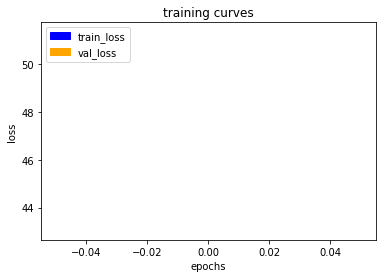

41/41 [==============================] - 43s 1s/step - loss: 51.3513 - val_loss: 43.0668
Epoch 2/200
40/41 [============================>.] - ETA: 0s - loss: 36.5333

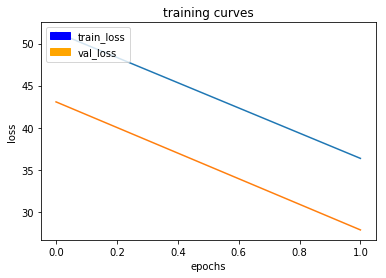

41/41 [==============================] - 28s 674ms/step - loss: 36.3458 - val_loss: 27.8355
Epoch 3/200
40/41 [============================>.] - ETA: 0s - loss: 21.4090

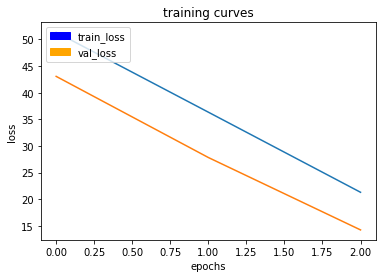

41/41 [==============================] - 28s 677ms/step - loss: 21.3098 - val_loss: 14.2442
Epoch 4/200
40/41 [============================>.] - ETA: 0s - loss: 11.8550

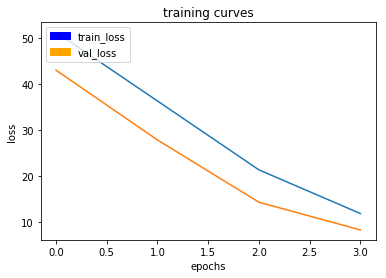

41/41 [==============================] - 28s 673ms/step - loss: 11.7777 - val_loss: 8.2041
Epoch 5/200
40/41 [============================>.] - ETA: 0s - loss: 7.1068

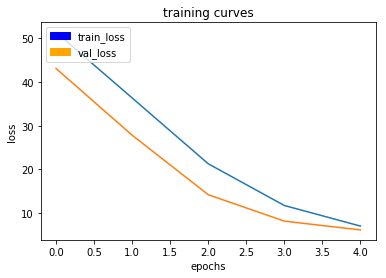

41/41 [==============================] - 28s 691ms/step - loss: 7.0732 - val_loss: 6.1976
Epoch 6/200
40/41 [============================>.] - ETA: 0s - loss: 5.1690

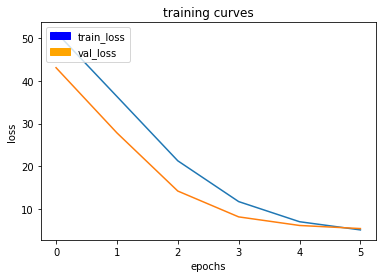

41/41 [==============================] - 28s 683ms/step - loss: 5.1584 - val_loss: 5.4742
Epoch 7/200
40/41 [============================>.] - ETA: 0s - loss: 3.9440

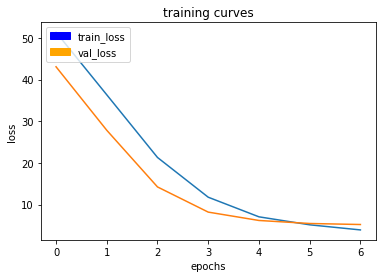

41/41 [==============================] - 28s 678ms/step - loss: 3.9328 - val_loss: 5.2285
Epoch 8/200
40/41 [============================>.] - ETA: 0s - loss: 3.2669

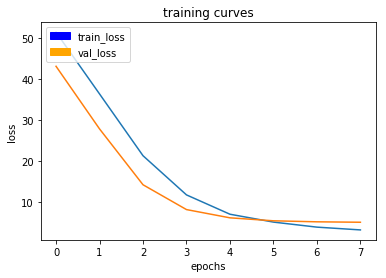

41/41 [==============================] - 28s 689ms/step - loss: 3.2563 - val_loss: 5.1217
Epoch 9/200
40/41 [============================>.] - ETA: 0s - loss: 2.7972

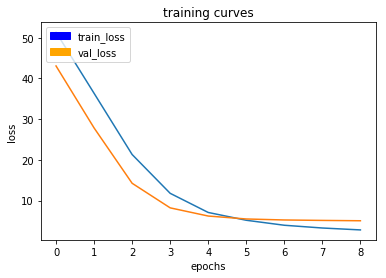

41/41 [==============================] - 28s 677ms/step - loss: 2.7868 - val_loss: 5.0371
Epoch 10/200
40/41 [============================>.] - ETA: 0s - loss: 2.4873

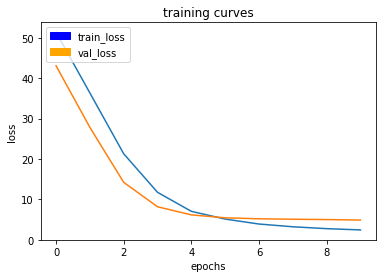

41/41 [==============================] - 28s 677ms/step - loss: 2.4764 - val_loss: 4.9135
Epoch 11/200
40/41 [============================>.] - ETA: 0s - loss: 2.4795

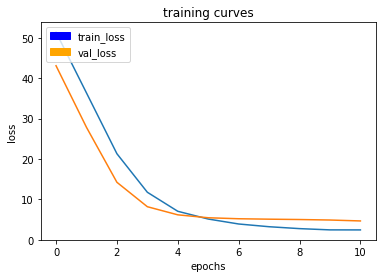

41/41 [==============================] - 28s 686ms/step - loss: 2.4669 - val_loss: 4.6859
Epoch 12/200
40/41 [============================>.] - ETA: 0s - loss: 2.2408

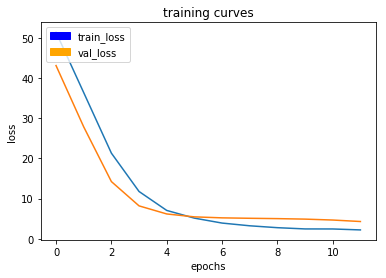

41/41 [==============================] - 28s 686ms/step - loss: 2.2310 - val_loss: 4.3189
Epoch 13/200
40/41 [============================>.] - ETA: 0s - loss: 1.9751

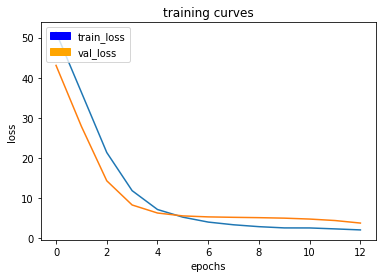

41/41 [==============================] - 28s 680ms/step - loss: 1.9752 - val_loss: 3.6851
Epoch 14/200
40/41 [============================>.] - ETA: 0s - loss: 1.9049

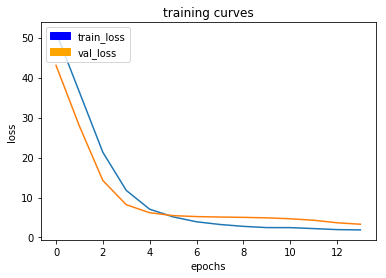

41/41 [==============================] - 28s 686ms/step - loss: 1.8960 - val_loss: 3.3154
Epoch 15/200
40/41 [============================>.] - ETA: 0s - loss: 1.8475

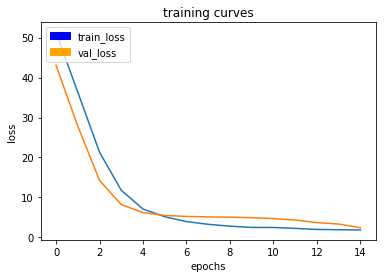

41/41 [==============================] - 28s 680ms/step - loss: 1.8521 - val_loss: 2.4146
Epoch 16/200
40/41 [============================>.] - ETA: 0s - loss: 1.8185

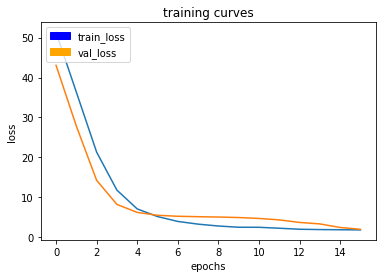

41/41 [==============================] - 28s 688ms/step - loss: 1.8084 - val_loss: 1.9743
Epoch 17/200
40/41 [============================>.] - ETA: 0s - loss: 1.6730

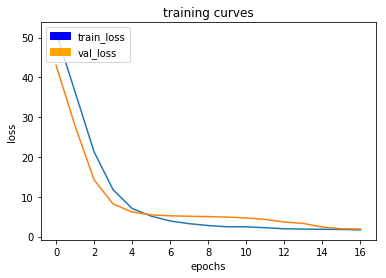

41/41 [==============================] - 28s 684ms/step - loss: 1.6903 - val_loss: 1.9182
Epoch 18/200
40/41 [============================>.] - ETA: 0s - loss: 1.8022

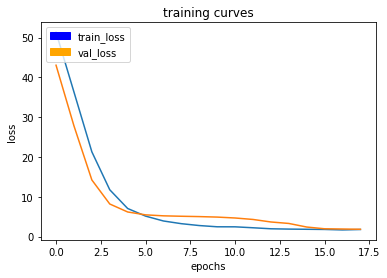

41/41 [==============================] - 28s 678ms/step - loss: 1.7948 - val_loss: 1.8522
Epoch 19/200
40/41 [============================>.] - ETA: 0s - loss: 1.5258

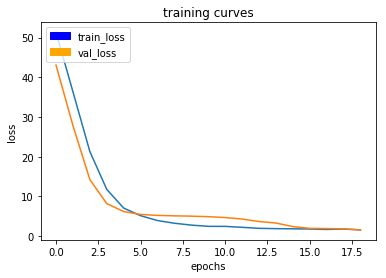

41/41 [==============================] - 28s 687ms/step - loss: 1.5786 - val_loss: 1.5748
Epoch 20/200
40/41 [============================>.] - ETA: 0s - loss: 1.5915

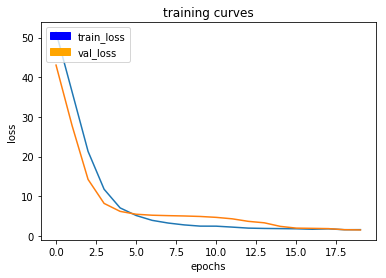

41/41 [==============================] - 28s 681ms/step - loss: 1.5874 - val_loss: 1.5230
Epoch 21/200
40/41 [============================>.] - ETA: 0s - loss: 1.6064

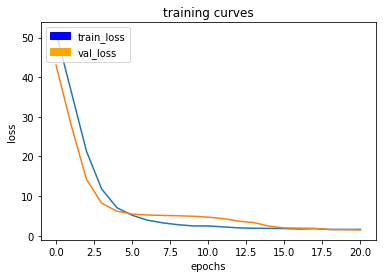

41/41 [==============================] - 28s 685ms/step - loss: 1.5982 - val_loss: 1.4673
Epoch 22/200
40/41 [============================>.] - ETA: 0s - loss: 1.4566

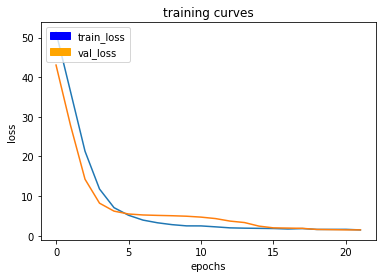

41/41 [==============================] - 28s 677ms/step - loss: 1.4555 - val_loss: 1.4649
Epoch 23/200
40/41 [============================>.] - ETA: 0s - loss: 1.3432

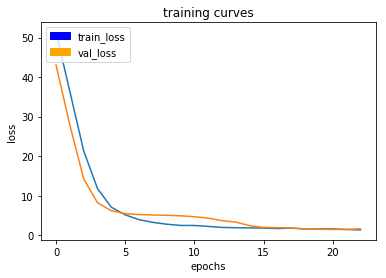

41/41 [==============================] - 28s 682ms/step - loss: 1.3442 - val_loss: 1.6351
Epoch 24/200
40/41 [============================>.] - ETA: 0s - loss: 1.5024

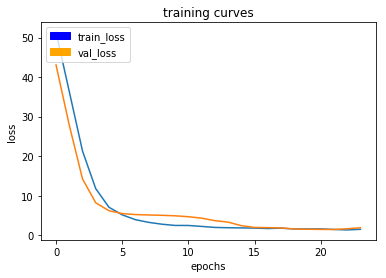

41/41 [==============================] - 28s 692ms/step - loss: 1.5002 - val_loss: 1.8941
Epoch 25/200
40/41 [============================>.] - ETA: 0s - loss: 1.2870

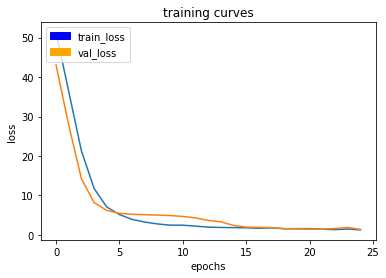

41/41 [==============================] - 28s 690ms/step - loss: 1.2716 - val_loss: 1.3945
Epoch 26/200
40/41 [============================>.] - ETA: 0s - loss: 1.3355

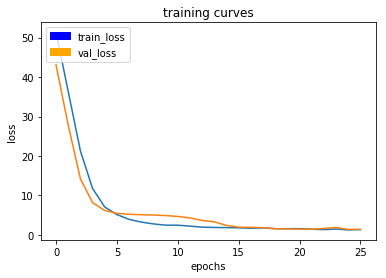

41/41 [==============================] - 28s 690ms/step - loss: 1.3578 - val_loss: 1.4061
Epoch 27/200
40/41 [============================>.] - ETA: 0s - loss: 1.1910

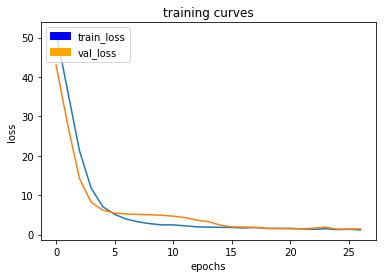

41/41 [==============================] - 28s 679ms/step - loss: 1.1940 - val_loss: 1.4694
Epoch 28/200
40/41 [============================>.] - ETA: 0s - loss: 1.4791

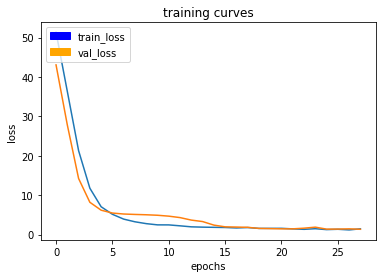

41/41 [==============================] - 28s 675ms/step - loss: 1.4729 - val_loss: 1.3562
Epoch 29/200
40/41 [============================>.] - ETA: 0s - loss: 1.2931

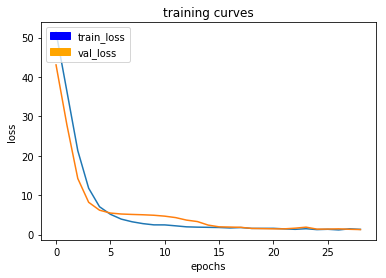

41/41 [==============================] - 28s 688ms/step - loss: 1.3318 - val_loss: 1.2842
Epoch 30/200
40/41 [============================>.] - ETA: 0s - loss: 1.2741

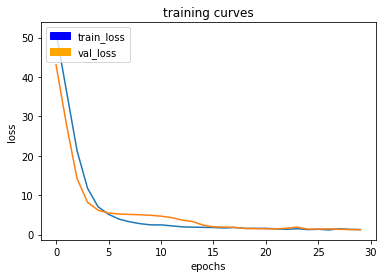

41/41 [==============================] - 28s 686ms/step - loss: 1.2858 - val_loss: 1.2454
Epoch 31/200
40/41 [============================>.] - ETA: 0s - loss: 1.2141

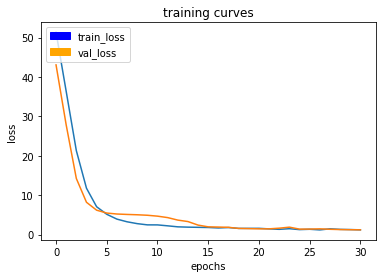

41/41 [==============================] - 28s 674ms/step - loss: 1.2109 - val_loss: 1.2165
Epoch 32/200
40/41 [============================>.] - ETA: 0s - loss: 1.2449

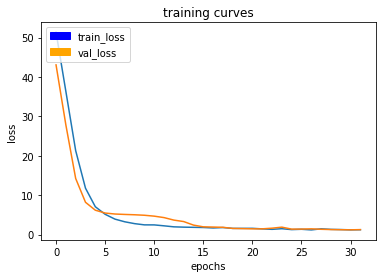

41/41 [==============================] - 28s 690ms/step - loss: 1.2407 - val_loss: 1.2676
Epoch 33/200
40/41 [============================>.] - ETA: 0s - loss: 1.1462

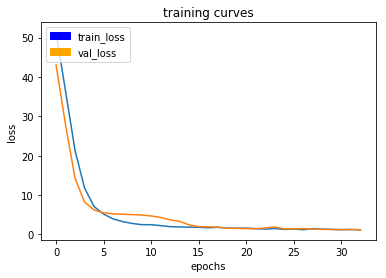

41/41 [==============================] - 28s 678ms/step - loss: 1.1419 - val_loss: 1.1780
Epoch 34/200
40/41 [============================>.] - ETA: 0s - loss: 1.2346

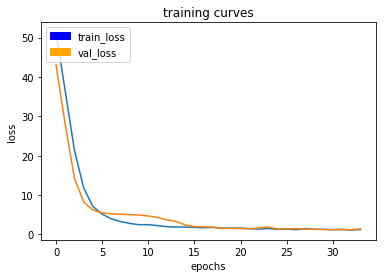

41/41 [==============================] - 28s 679ms/step - loss: 1.2291 - val_loss: 1.4130
Epoch 35/200
40/41 [============================>.] - ETA: 0s - loss: 1.0862

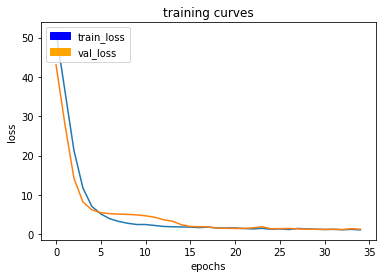

41/41 [==============================] - 28s 680ms/step - loss: 1.0950 - val_loss: 1.2612
Epoch 36/200
40/41 [============================>.] - ETA: 0s - loss: 1.2114

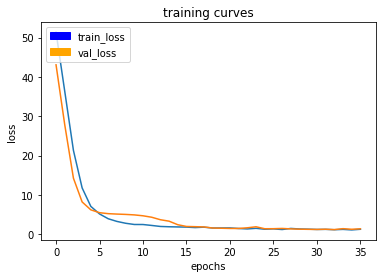

41/41 [==============================] - 28s 681ms/step - loss: 1.2610 - val_loss: 1.3777
Epoch 37/200
40/41 [============================>.] - ETA: 0s - loss: 1.0924

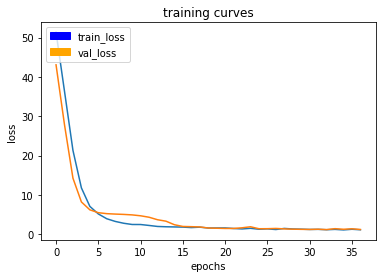

41/41 [==============================] - 28s 691ms/step - loss: 1.1328 - val_loss: 1.2018
Epoch 38/200
40/41 [============================>.] - ETA: 0s - loss: 1.0678

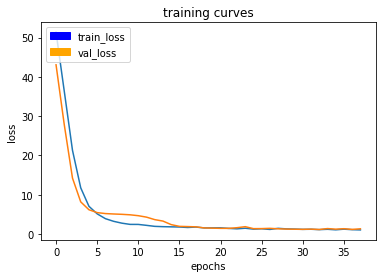

41/41 [==============================] - 28s 683ms/step - loss: 1.0697 - val_loss: 1.3536
Epoch 39/200
40/41 [============================>.] - ETA: 0s - loss: 1.1198

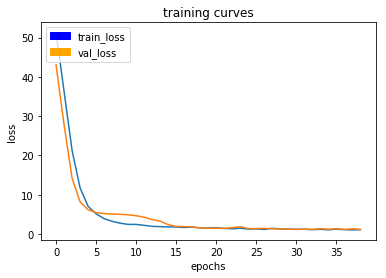

41/41 [==============================] - 28s 677ms/step - loss: 1.1173 - val_loss: 1.2099
Epoch 40/200
40/41 [============================>.] - ETA: 0s - loss: 1.0621

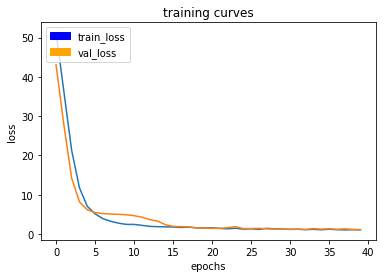

41/41 [==============================] - 28s 684ms/step - loss: 1.0752 - val_loss: 1.1610
Epoch 41/200
40/41 [============================>.] - ETA: 0s - loss: 1.1773

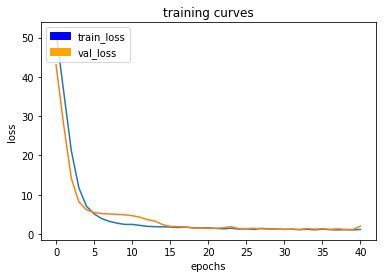

41/41 [==============================] - 28s 689ms/step - loss: 1.1896 - val_loss: 2.0311
Epoch 42/200
40/41 [============================>.] - ETA: 0s - loss: 1.1402

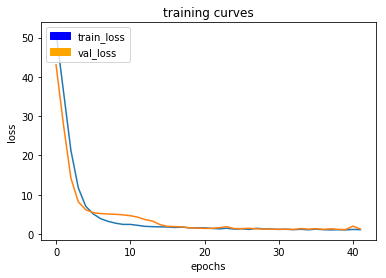

41/41 [==============================] - 28s 686ms/step - loss: 1.1378 - val_loss: 1.2881
Epoch 43/200
40/41 [============================>.] - ETA: 0s - loss: 1.0173

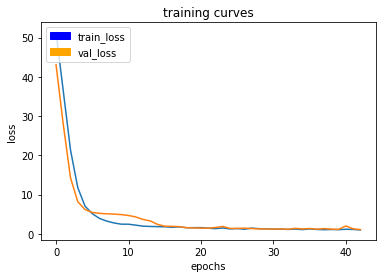

41/41 [==============================] - 28s 695ms/step - loss: 1.0156 - val_loss: 1.0878
Epoch 44/200
40/41 [============================>.] - ETA: 0s - loss: 1.0160

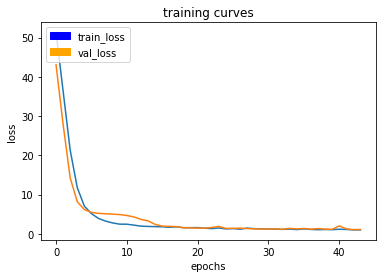

41/41 [==============================] - 28s 684ms/step - loss: 1.0130 - val_loss: 1.1295
Epoch 45/200
40/41 [============================>.] - ETA: 0s - loss: 1.0212

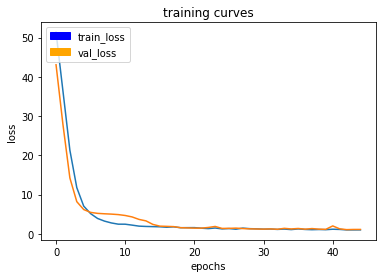

41/41 [==============================] - 28s 684ms/step - loss: 1.0203 - val_loss: 1.1337
Epoch 46/200
40/41 [============================>.] - ETA: 0s - loss: 1.0327

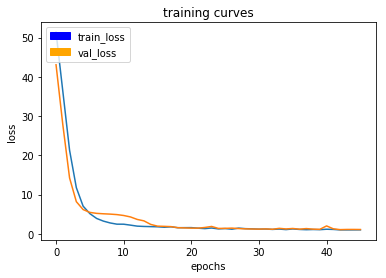

41/41 [==============================] - 28s 680ms/step - loss: 1.0294 - val_loss: 1.1161
Epoch 47/200
40/41 [============================>.] - ETA: 0s - loss: 1.0761

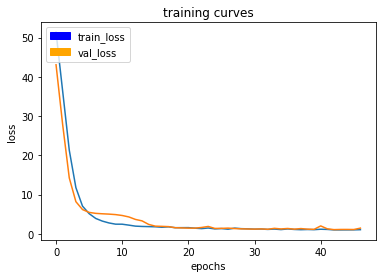

41/41 [==============================] - 28s 680ms/step - loss: 1.0715 - val_loss: 1.4652
Epoch 48/200
40/41 [============================>.] - ETA: 0s - loss: 1.0277

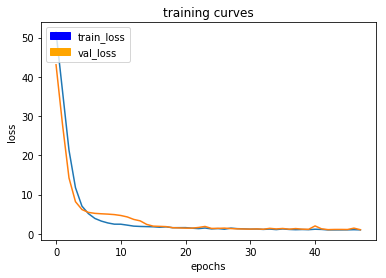

41/41 [==============================] - 28s 686ms/step - loss: 1.0224 - val_loss: 1.0630
Epoch 49/200
40/41 [============================>.] - ETA: 0s - loss: 0.9533

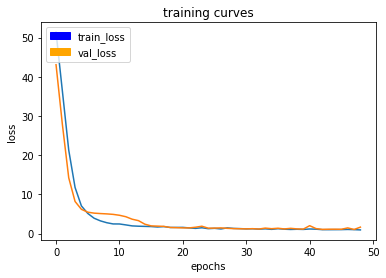

41/41 [==============================] - 28s 688ms/step - loss: 0.9513 - val_loss: 1.6573
Epoch 50/200
40/41 [============================>.] - ETA: 0s - loss: 1.1920

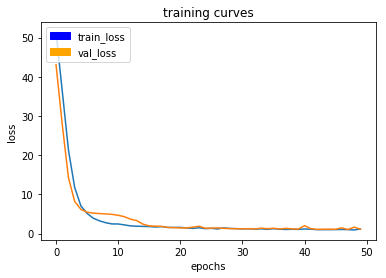

41/41 [==============================] - 28s 682ms/step - loss: 1.1864 - val_loss: 1.1364
Epoch 51/200
40/41 [============================>.] - ETA: 0s - loss: 0.9335

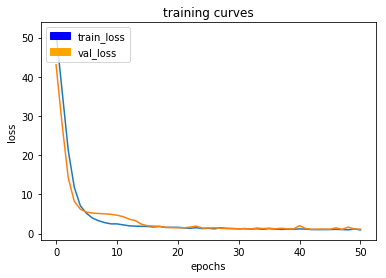

41/41 [==============================] - 28s 680ms/step - loss: 0.9305 - val_loss: 1.1358
Epoch 52/200
40/41 [============================>.] - ETA: 0s - loss: 0.8974

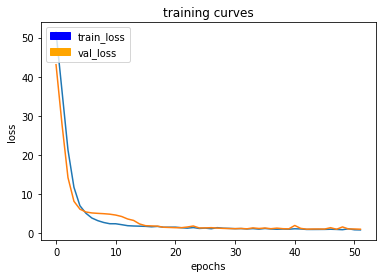

41/41 [==============================] - 28s 689ms/step - loss: 0.8960 - val_loss: 1.0736
Epoch 53/200
40/41 [============================>.] - ETA: 0s - loss: 1.0006

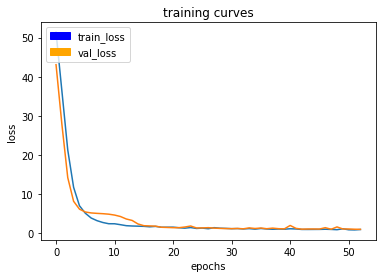

41/41 [==============================] - 28s 690ms/step - loss: 0.9981 - val_loss: 1.0439
Epoch 54/200
40/41 [============================>.] - ETA: 0s - loss: 0.8845

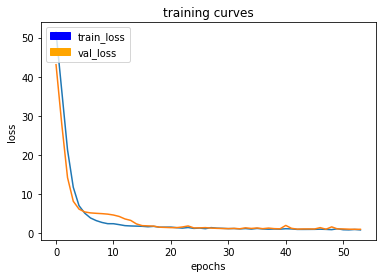

41/41 [==============================] - 28s 682ms/step - loss: 0.8839 - val_loss: 1.0407
Epoch 55/200
40/41 [============================>.] - ETA: 0s - loss: 0.9630

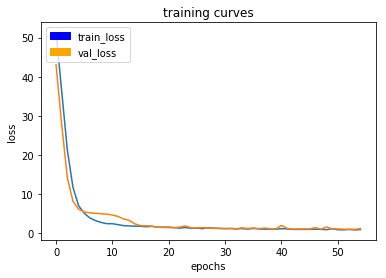

41/41 [==============================] - 28s 678ms/step - loss: 0.9609 - val_loss: 1.2088
Epoch 56/200
40/41 [============================>.] - ETA: 0s - loss: 0.9134

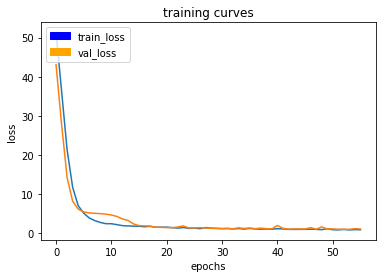

41/41 [==============================] - 28s 680ms/step - loss: 0.9101 - val_loss: 1.1366
Epoch 57/200
40/41 [============================>.] - ETA: 0s - loss: 0.8847

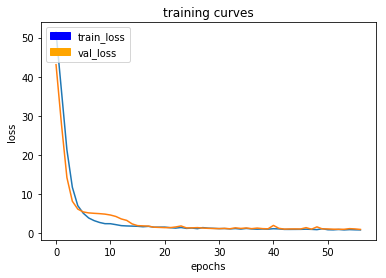

41/41 [==============================] - 28s 675ms/step - loss: 0.8818 - val_loss: 1.0037
Epoch 58/200
40/41 [============================>.] - ETA: 0s - loss: 0.9471

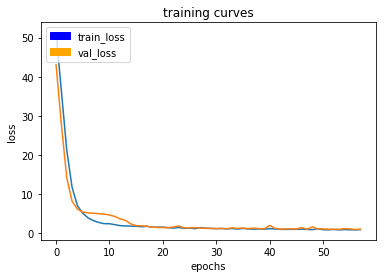

41/41 [==============================] - 28s 677ms/step - loss: 0.9462 - val_loss: 1.0792
Epoch 59/200
40/41 [============================>.] - ETA: 0s - loss: 0.8648

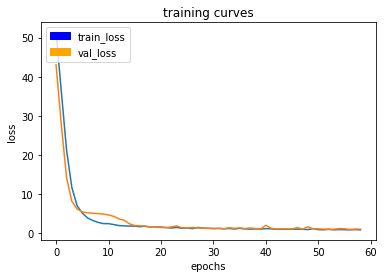

41/41 [==============================] - 28s 675ms/step - loss: 0.8633 - val_loss: 1.0766
Epoch 60/200
40/41 [============================>.] - ETA: 0s - loss: 0.8786

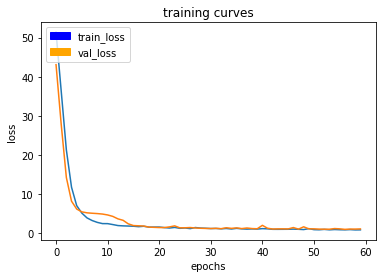

41/41 [==============================] - 28s 672ms/step - loss: 0.8808 - val_loss: 1.1183
Epoch 61/200
40/41 [============================>.] - ETA: 0s - loss: 0.8072

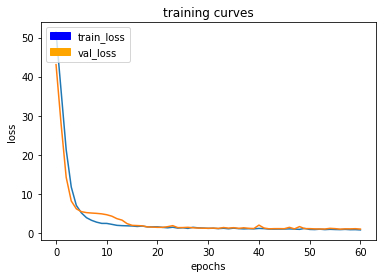

41/41 [==============================] - 28s 688ms/step - loss: 0.8062 - val_loss: 1.0212
Epoch 62/200
40/41 [============================>.] - ETA: 0s - loss: 0.9080

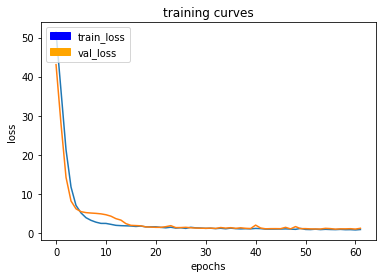

41/41 [==============================] - 28s 678ms/step - loss: 0.9079 - val_loss: 1.2181
Epoch 63/200
40/41 [============================>.] - ETA: 0s - loss: 1.0319

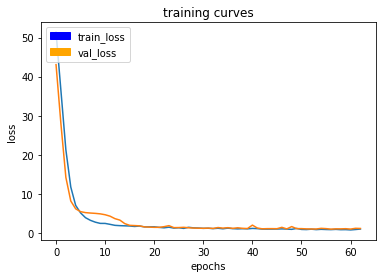

41/41 [==============================] - 28s 677ms/step - loss: 1.0303 - val_loss: 1.1753
Epoch 64/200
40/41 [============================>.] - ETA: 0s - loss: 0.9219

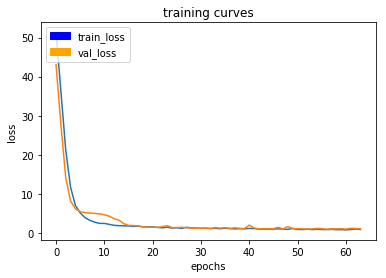

41/41 [==============================] - 28s 679ms/step - loss: 0.9232 - val_loss: 1.0876
Epoch 65/200
40/41 [============================>.] - ETA: 0s - loss: 0.7984

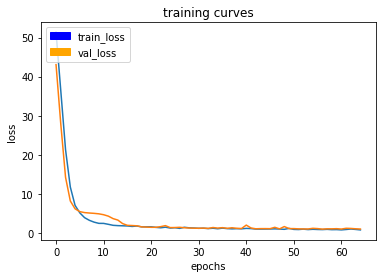

41/41 [==============================] - 28s 680ms/step - loss: 0.7994 - val_loss: 1.0277
Epoch 66/200
40/41 [============================>.] - ETA: 0s - loss: 0.8109

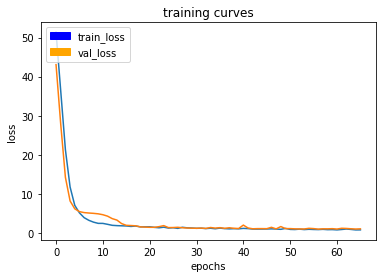

41/41 [==============================] - 28s 688ms/step - loss: 0.8109 - val_loss: 1.0755
Epoch 67/200
40/41 [============================>.] - ETA: 0s - loss: 0.9936

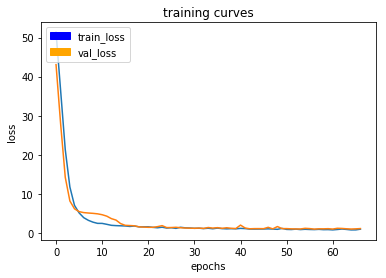

41/41 [==============================] - 28s 680ms/step - loss: 0.9923 - val_loss: 1.1425
Epoch 68/200
40/41 [============================>.] - ETA: 0s - loss: 0.8952

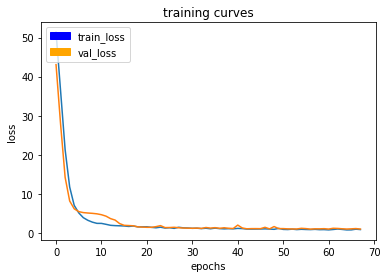

41/41 [==============================] - 28s 686ms/step - loss: 0.8928 - val_loss: 1.0179
Epoch 69/200
40/41 [============================>.] - ETA: 0s - loss: 0.8321

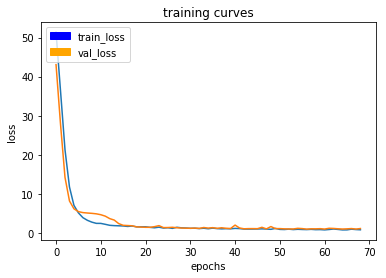

41/41 [==============================] - 28s 686ms/step - loss: 0.8334 - val_loss: 1.1516
Epoch 70/200
40/41 [============================>.] - ETA: 0s - loss: 0.8052

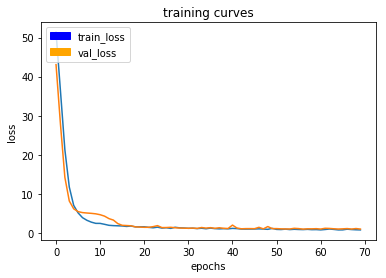

41/41 [==============================] - 28s 679ms/step - loss: 0.8006 - val_loss: 1.0203
Epoch 71/200
40/41 [============================>.] - ETA: 0s - loss: 0.7567

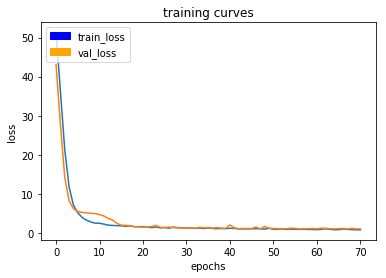

41/41 [==============================] - 28s 684ms/step - loss: 0.7549 - val_loss: 1.0185
Epoch 72/200
40/41 [============================>.] - ETA: 0s - loss: 0.7743

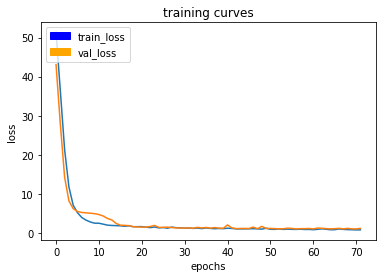

41/41 [==============================] - 28s 681ms/step - loss: 0.7731 - val_loss: 1.1379
Epoch 73/200
40/41 [============================>.] - ETA: 0s - loss: 0.9339

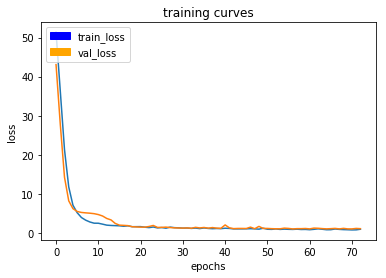

41/41 [==============================] - 28s 689ms/step - loss: 0.9306 - val_loss: 1.0722
Epoch 74/200
40/41 [============================>.] - ETA: 0s - loss: 0.7905

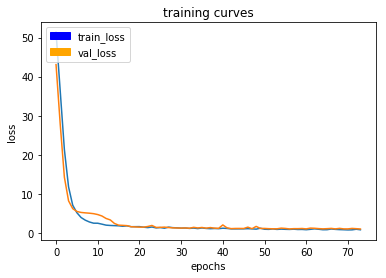

41/41 [==============================] - 28s 691ms/step - loss: 0.7916 - val_loss: 0.9914
Epoch 75/200
40/41 [============================>.] - ETA: 0s - loss: 0.7531

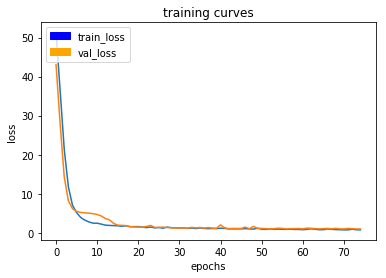

41/41 [==============================] - 28s 679ms/step - loss: 0.7503 - val_loss: 0.9969
Epoch 76/200
40/41 [============================>.] - ETA: 0s - loss: 0.8433

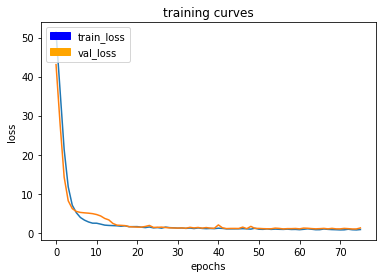

41/41 [==============================] - 28s 682ms/step - loss: 0.8456 - val_loss: 1.2541
Epoch 77/200
40/41 [============================>.] - ETA: 0s - loss: 0.8652

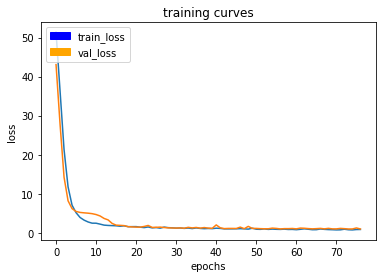

41/41 [==============================] - 28s 682ms/step - loss: 0.8651 - val_loss: 0.9904
Epoch 78/200
40/41 [============================>.] - ETA: 0s - loss: 0.8372

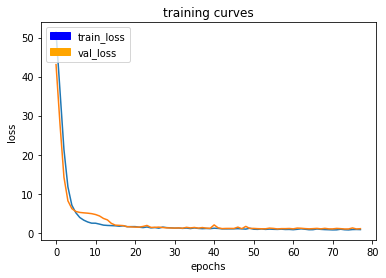

41/41 [==============================] - 28s 695ms/step - loss: 0.8357 - val_loss: 1.0679
Epoch 79/200
40/41 [============================>.] - ETA: 0s - loss: 0.7849

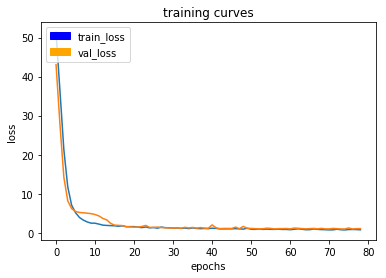

41/41 [==============================] - 28s 690ms/step - loss: 0.7817 - val_loss: 1.0877
Epoch 80/200
40/41 [============================>.] - ETA: 0s - loss: 0.8503

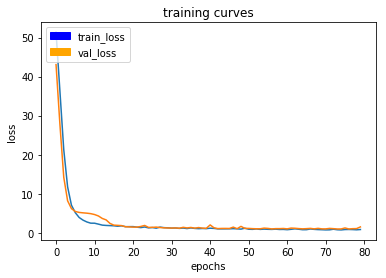

41/41 [==============================] - 28s 679ms/step - loss: 0.8518 - val_loss: 1.5187
Epoch 81/200
40/41 [============================>.] - ETA: 0s - loss: 0.7961

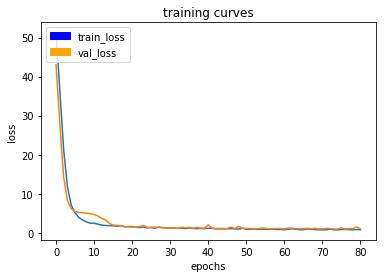

41/41 [==============================] - 28s 677ms/step - loss: 0.7922 - val_loss: 1.0170
Epoch 82/200
40/41 [============================>.] - ETA: 0s - loss: 0.7253

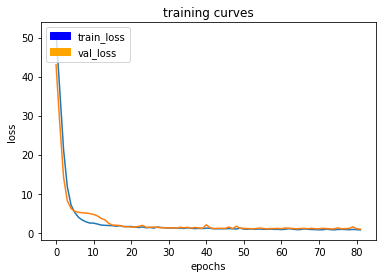

41/41 [==============================] - 28s 683ms/step - loss: 0.7257 - val_loss: 0.9379
Epoch 83/200
40/41 [============================>.] - ETA: 0s - loss: 0.7771

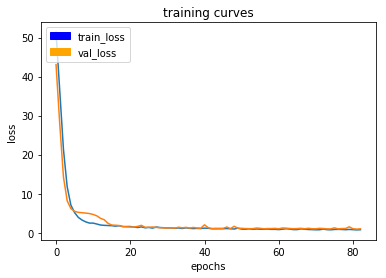

41/41 [==============================] - 28s 685ms/step - loss: 0.7758 - val_loss: 1.0011
Epoch 84/200
40/41 [============================>.] - ETA: 0s - loss: 0.7711

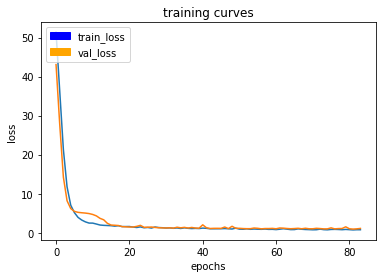

41/41 [==============================] - 28s 679ms/step - loss: 0.7715 - val_loss: 1.1049
Epoch 85/200
40/41 [============================>.] - ETA: 0s - loss: 0.7288

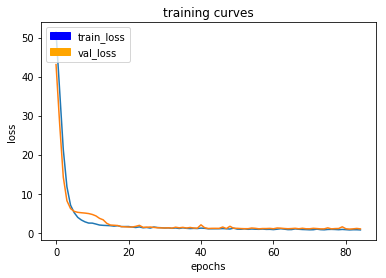

41/41 [==============================] - 28s 676ms/step - loss: 0.7266 - val_loss: 0.9917
Epoch 86/200
40/41 [============================>.] - ETA: 0s - loss: 0.7357

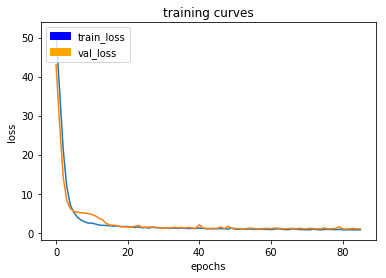

41/41 [==============================] - 28s 679ms/step - loss: 0.7308 - val_loss: 1.0053
Epoch 87/200
40/41 [============================>.] - ETA: 0s - loss: 0.7363

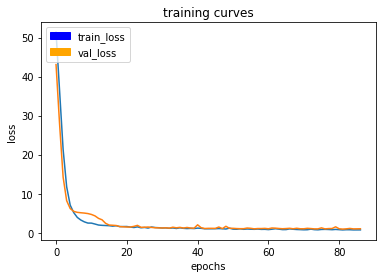

41/41 [==============================] - 28s 687ms/step - loss: 0.7343 - val_loss: 1.0230
Epoch 88/200
40/41 [============================>.] - ETA: 0s - loss: 0.6726

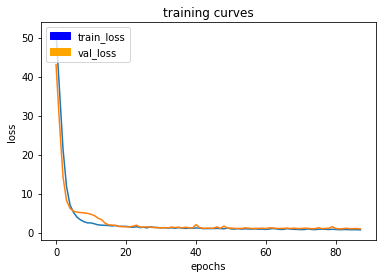

41/41 [==============================] - 28s 691ms/step - loss: 0.6751 - val_loss: 0.9643
Epoch 89/200
40/41 [============================>.] - ETA: 0s - loss: 0.6682

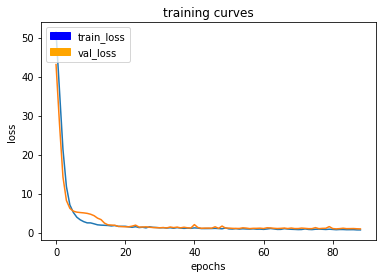

41/41 [==============================] - 28s 688ms/step - loss: 0.6687 - val_loss: 0.9345
Epoch 90/200
40/41 [============================>.] - ETA: 0s - loss: 0.6730

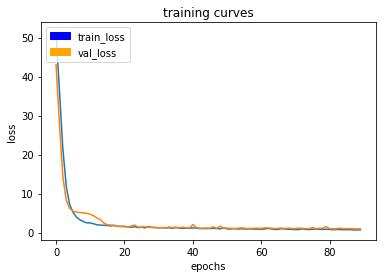

41/41 [==============================] - 28s 674ms/step - loss: 0.6723 - val_loss: 0.9577
Epoch 91/200
40/41 [============================>.] - ETA: 0s - loss: 0.8198

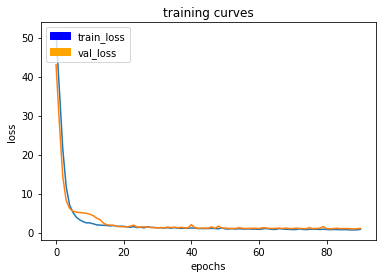

41/41 [==============================] - 28s 675ms/step - loss: 0.8186 - val_loss: 1.0609
Epoch 92/200
40/41 [============================>.] - ETA: 0s - loss: 0.7426

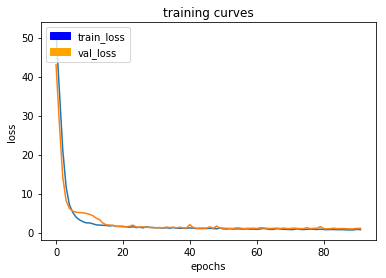

41/41 [==============================] - 28s 685ms/step - loss: 0.7385 - val_loss: 1.0663
Epoch 93/200
40/41 [============================>.] - ETA: 0s - loss: 0.6702

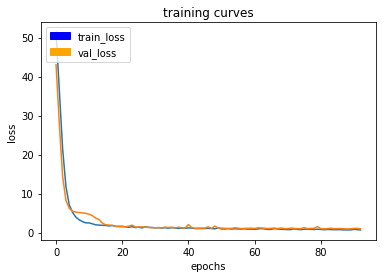

41/41 [==============================] - 28s 685ms/step - loss: 0.6693 - val_loss: 0.9857
Epoch 94/200
40/41 [============================>.] - ETA: 0s - loss: 0.7038

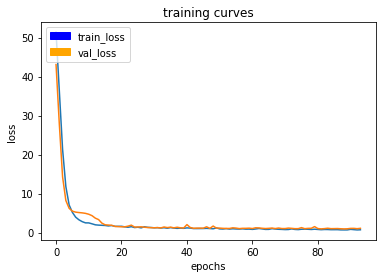

41/41 [==============================] - 28s 679ms/step - loss: 0.7026 - val_loss: 1.0761
Epoch 95/200
40/41 [============================>.] - ETA: 0s - loss: 0.6824

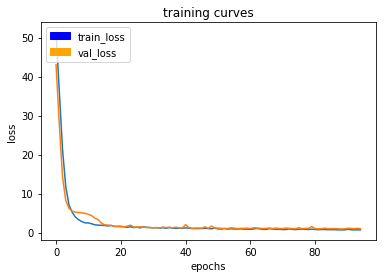

41/41 [==============================] - 28s 690ms/step - loss: 0.6813 - val_loss: 1.0149
Epoch 96/200
40/41 [============================>.] - ETA: 0s - loss: 0.7050

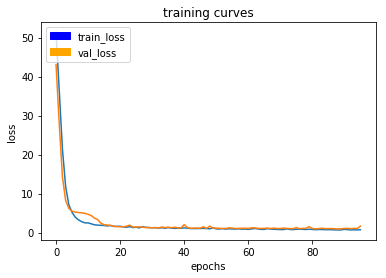

41/41 [==============================] - 28s 677ms/step - loss: 0.7065 - val_loss: 1.6476
Epoch 97/200
40/41 [============================>.] - ETA: 8:20 - loss: 0.9061 

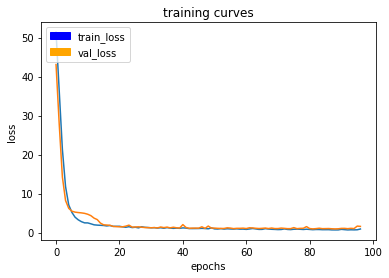

41/41 [==============================] - 20041s 489s/step - loss: 0.9028 - val_loss: 1.5722
Epoch 98/200
40/41 [============================>.] - ETA: 0s - loss: 0.8124

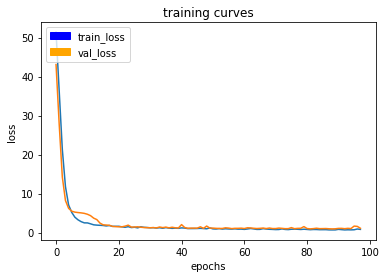

41/41 [==============================] - 27s 667ms/step - loss: 0.8100 - val_loss: 1.0918
Epoch 99/200
40/41 [============================>.] - ETA: 0s - loss: 0.8590

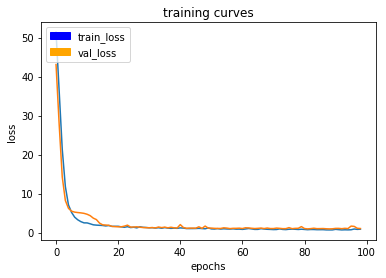

41/41 [==============================] - 28s 673ms/step - loss: 0.8607 - val_loss: 1.0227
Epoch 100/200
40/41 [============================>.] - ETA: 0s - loss: 0.7526

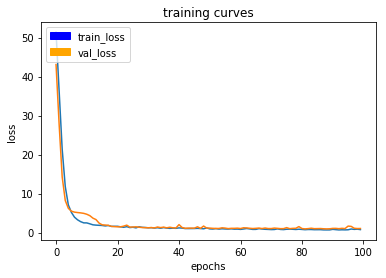

41/41 [==============================] - 28s 675ms/step - loss: 0.7524 - val_loss: 1.0314
Epoch 101/200
40/41 [============================>.] - ETA: 0s - loss: 0.6692

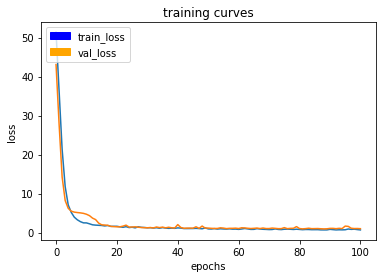

41/41 [==============================] - 28s 681ms/step - loss: 0.6678 - val_loss: 0.9837
Epoch 102/200
40/41 [============================>.] - ETA: 0s - loss: 0.6319

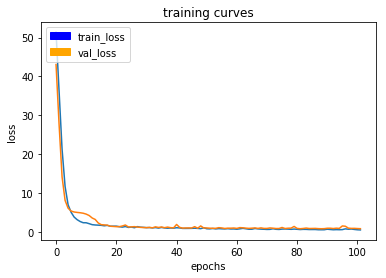

41/41 [==============================] - 28s 675ms/step - loss: 0.6304 - val_loss: 0.9465
Epoch 103/200
40/41 [============================>.] - ETA: 0s - loss: 0.7014

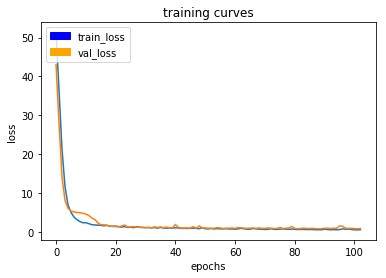

41/41 [==============================] - 28s 685ms/step - loss: 0.7017 - val_loss: 0.9882
Epoch 104/200
40/41 [============================>.] - ETA: 0s - loss: 0.6420

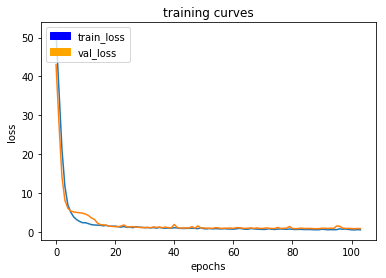

41/41 [==============================] - 30s 729ms/step - loss: 0.6403 - val_loss: 0.9665
Epoch 105/200
40/41 [============================>.] - ETA: 0s - loss: 0.6600

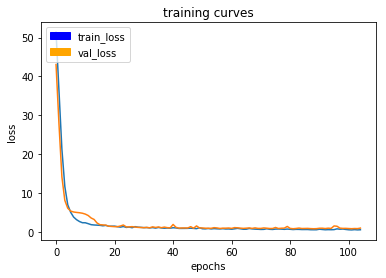

41/41 [==============================] - 28s 694ms/step - loss: 0.6701 - val_loss: 1.0942
Epoch 106/200
40/41 [============================>.] - ETA: 0s - loss: 0.6648

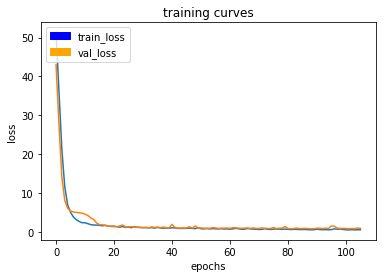

41/41 [==============================] - 28s 683ms/step - loss: 0.6654 - val_loss: 1.0353
Epoch 107/200
40/41 [============================>.] - ETA: 0s - loss: 0.6820

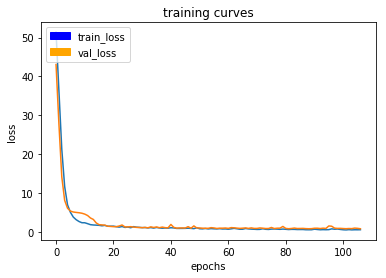

41/41 [==============================] - 28s 677ms/step - loss: 0.6806 - val_loss: 0.9288
Epoch 108/200
40/41 [============================>.] - ETA: 0s - loss: 0.6403

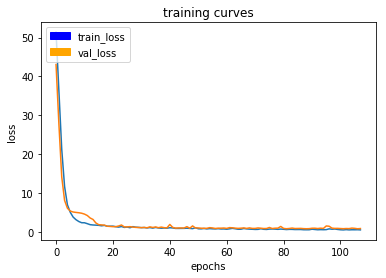

41/41 [==============================] - 28s 679ms/step - loss: 0.6406 - val_loss: 0.9832
Epoch 109/200
40/41 [============================>.] - ETA: 0s - loss: 0.6265

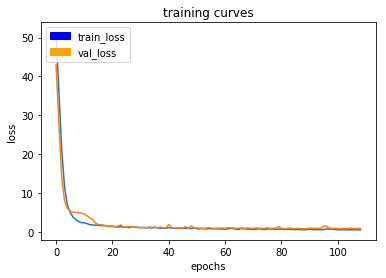

41/41 [==============================] - 28s 675ms/step - loss: 0.6271 - val_loss: 1.0181
Epoch 110/200
40/41 [============================>.] - ETA: 0s - loss: 0.6938

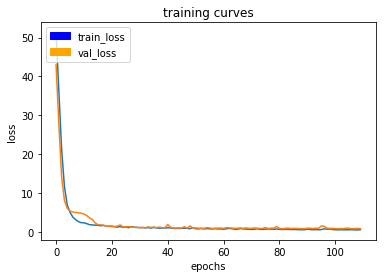

41/41 [==============================] - 28s 675ms/step - loss: 0.6931 - val_loss: 0.9532
Epoch 111/200
40/41 [============================>.] - ETA: 0s - loss: 0.6565

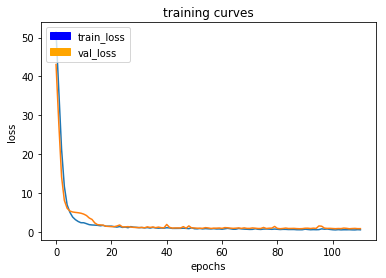

41/41 [==============================] - 28s 678ms/step - loss: 0.6553 - val_loss: 0.9539
Epoch 112/200
40/41 [============================>.] - ETA: 0s - loss: 0.6348

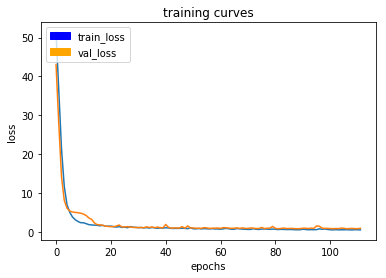

41/41 [==============================] - 28s 678ms/step - loss: 0.6316 - val_loss: 1.0338
Epoch 113/200
40/41 [============================>.] - ETA: 0s - loss: 0.6144

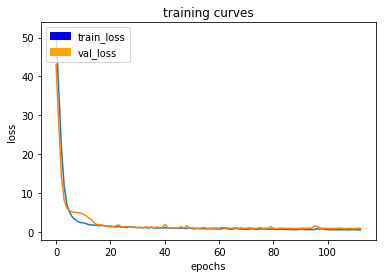

41/41 [==============================] - 28s 676ms/step - loss: 0.6120 - val_loss: 1.0332
Epoch 114/200
40/41 [============================>.] - ETA: 0s - loss: 0.6747

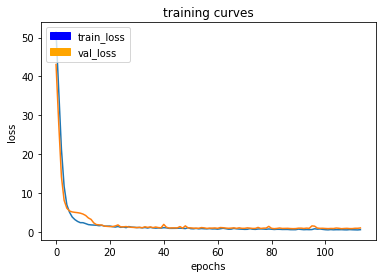

41/41 [==============================] - 28s 674ms/step - loss: 0.6740 - val_loss: 1.1136
Epoch 115/200
40/41 [============================>.] - ETA: 0s - loss: 0.6329

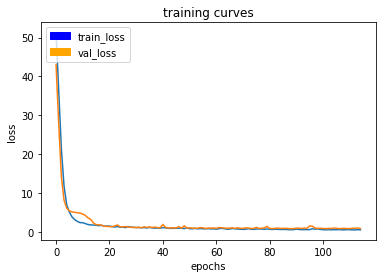

41/41 [==============================] - 28s 672ms/step - loss: 0.6299 - val_loss: 0.9607
Epoch 116/200
40/41 [============================>.] - ETA: 0s - loss: 0.6134

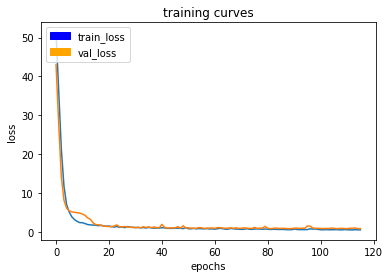

41/41 [==============================] - 28s 682ms/step - loss: 0.6160 - val_loss: 0.9455
Epoch 117/200
40/41 [============================>.] - ETA: 0s - loss: 0.5846

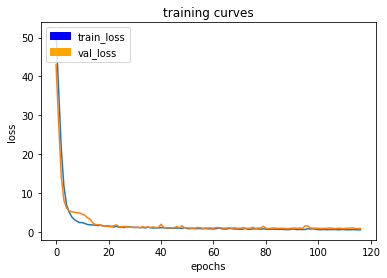

41/41 [==============================] - 28s 677ms/step - loss: 0.5838 - val_loss: 0.9605
Epoch 118/200
40/41 [============================>.] - ETA: 0s - loss: 0.6684

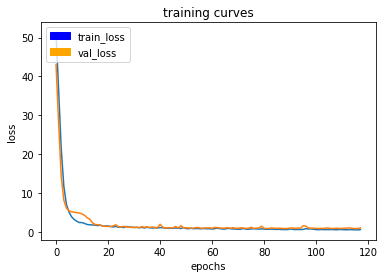

41/41 [==============================] - 28s 682ms/step - loss: 0.6672 - val_loss: 1.1032
Epoch 119/200
40/41 [============================>.] - ETA: 0s - loss: 0.7514

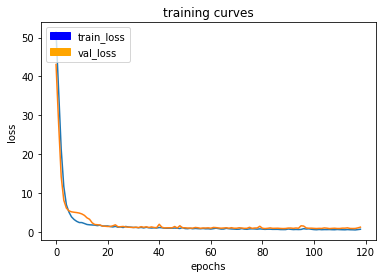

41/41 [==============================] - 28s 672ms/step - loss: 0.7532 - val_loss: 1.2882
Epoch 120/200
40/41 [============================>.] - ETA: 0s - loss: 0.7298

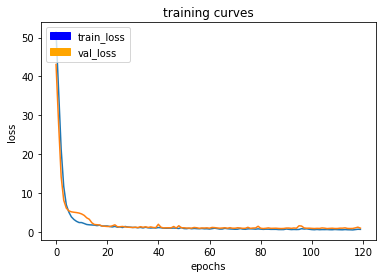

41/41 [==============================] - 27s 668ms/step - loss: 0.7301 - val_loss: 1.0372
Epoch 121/200
40/41 [============================>.] - ETA: 0s - loss: 0.6808

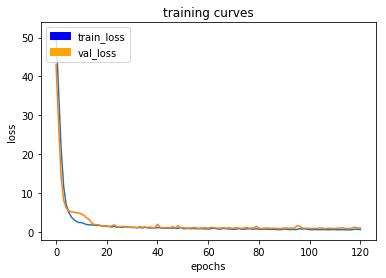

41/41 [==============================] - 28s 679ms/step - loss: 0.6806 - val_loss: 1.0630
Epoch 122/200
40/41 [============================>.] - ETA: 0s - loss: 0.6272

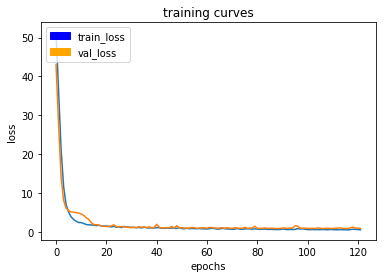

41/41 [==============================] - 28s 673ms/step - loss: 0.6266 - val_loss: 0.9603
Epoch 123/200
40/41 [============================>.] - ETA: 0s - loss: 0.6801

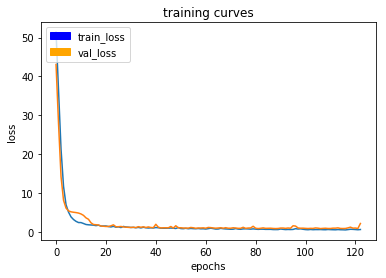

41/41 [==============================] - 28s 679ms/step - loss: 0.6882 - val_loss: 2.2346
Epoch 124/200
40/41 [============================>.] - ETA: 0s - loss: 0.9664

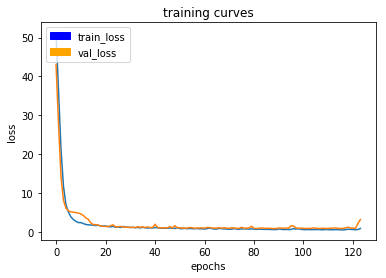

41/41 [==============================] - 28s 673ms/step - loss: 0.9630 - val_loss: 3.2494
Epoch 125/200
40/41 [============================>.] - ETA: 0s - loss: 0.9249

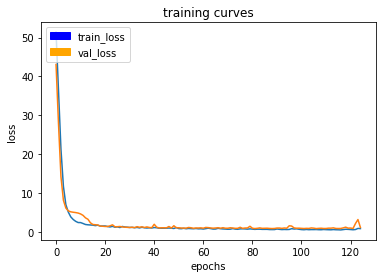

41/41 [==============================] - 27s 669ms/step - loss: 0.9210 - val_loss: 1.2153
Epoch 126/200
40/41 [============================>.] - ETA: 0s - loss: 0.7853

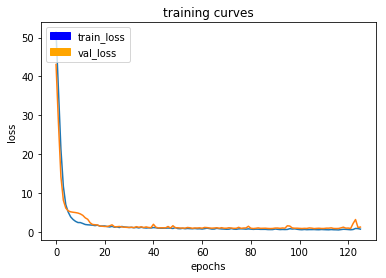

41/41 [==============================] - 28s 681ms/step - loss: 0.7860 - val_loss: 1.3136
Epoch 127/200
40/41 [============================>.] - ETA: 0s - loss: 0.7786

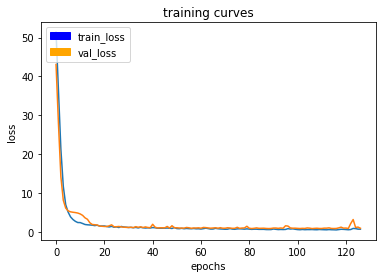

41/41 [==============================] - 28s 676ms/step - loss: 0.7757 - val_loss: 1.0145
Epoch 128/200
40/41 [============================>.] - ETA: 0s - loss: 0.6685

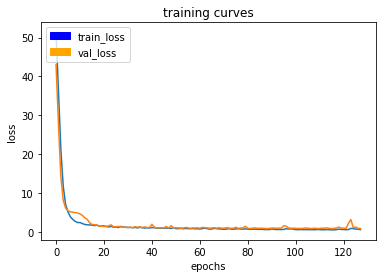

41/41 [==============================] - 28s 676ms/step - loss: 0.6684 - val_loss: 0.9386
Epoch 129/200
40/41 [============================>.] - ETA: 0s - loss: 0.6684

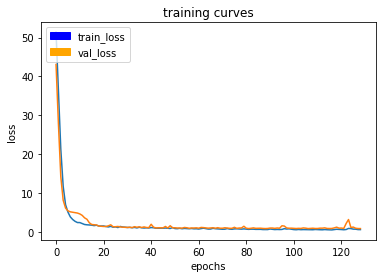

41/41 [==============================] - 28s 685ms/step - loss: 0.6659 - val_loss: 0.9273
Epoch 130/200
40/41 [============================>.] - ETA: 0s - loss: 0.6119

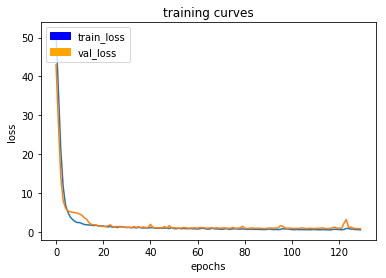

41/41 [==============================] - 28s 682ms/step - loss: 0.6155 - val_loss: 0.9186
Epoch 131/200
40/41 [============================>.] - ETA: 0s - loss: 0.6421

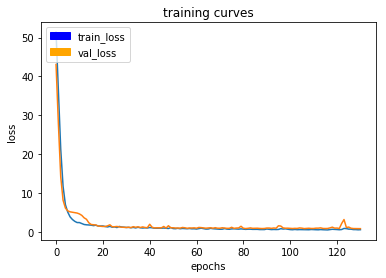

41/41 [==============================] - 27s 668ms/step - loss: 0.6427 - val_loss: 0.9091
Epoch 132/200
40/41 [============================>.] - ETA: 0s - loss: 0.5926

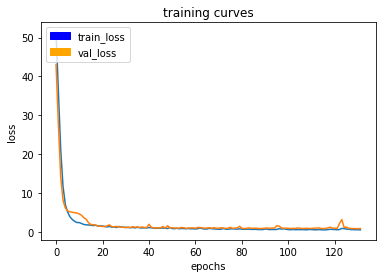

41/41 [==============================] - 28s 680ms/step - loss: 0.5917 - val_loss: 0.9363
Epoch 133/200
40/41 [============================>.] - ETA: 0s - loss: 0.6026

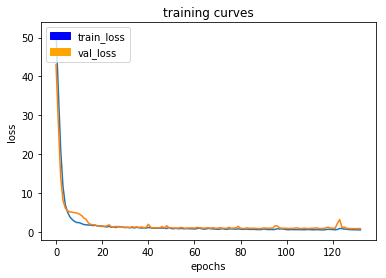

41/41 [==============================] - 28s 672ms/step - loss: 0.6015 - val_loss: 0.9155
Epoch 134/200
40/41 [============================>.] - ETA: 0s - loss: 0.5845

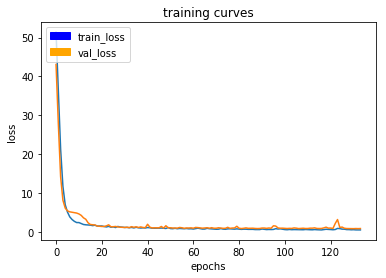

41/41 [==============================] - 28s 673ms/step - loss: 0.5843 - val_loss: 0.9381
Epoch 135/200
40/41 [============================>.] - ETA: 0s - loss: 0.6150

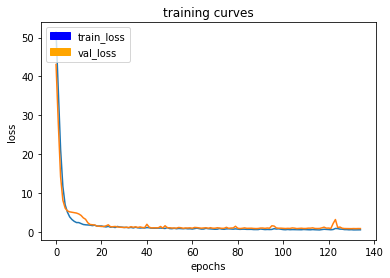

41/41 [==============================] - 28s 680ms/step - loss: 0.6143 - val_loss: 0.9286
Epoch 136/200
40/41 [============================>.] - ETA: 0s - loss: 0.5766

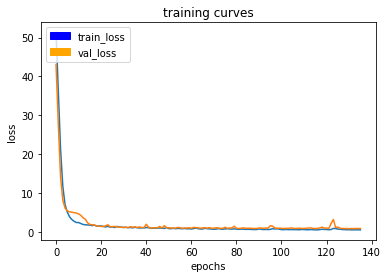

41/41 [==============================] - 27s 664ms/step - loss: 0.5777 - val_loss: 0.9454
Epoch 137/200
40/41 [============================>.] - ETA: 0s - loss: 0.7879

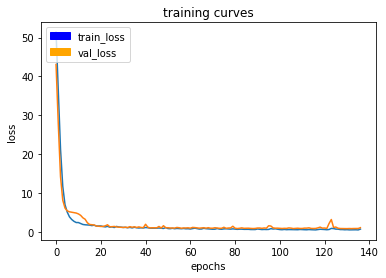

41/41 [==============================] - 28s 674ms/step - loss: 0.7829 - val_loss: 1.1462
Epoch 138/200
40/41 [============================>.] - ETA: 0s - loss: 0.6359

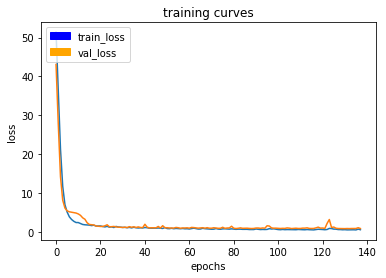

41/41 [==============================] - 27s 670ms/step - loss: 0.6352 - val_loss: 0.9365
Epoch 139/200
40/41 [============================>.] - ETA: 0s - loss: 0.6073

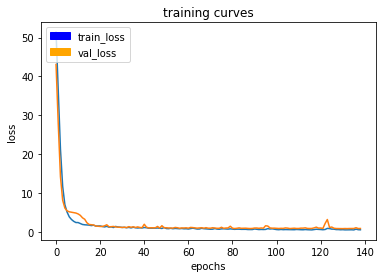

41/41 [==============================] - 28s 683ms/step - loss: 0.6138 - val_loss: 0.9453
Epoch 140/200
40/41 [============================>.] - ETA: 0s - loss: 0.6673

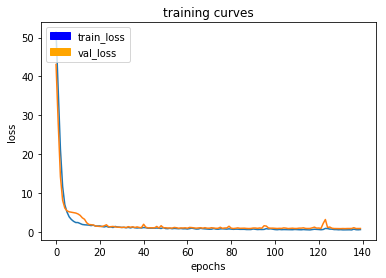

41/41 [==============================] - 28s 674ms/step - loss: 0.6622 - val_loss: 0.9467
Epoch 141/200
40/41 [============================>.] - ETA: 0s - loss: 0.6017

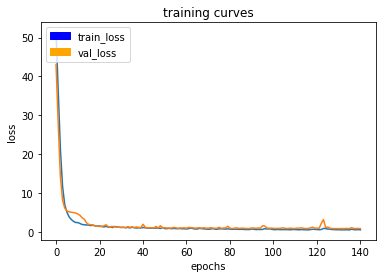

41/41 [==============================] - 28s 684ms/step - loss: 0.6014 - val_loss: 0.9217
Epoch 142/200
40/41 [============================>.] - ETA: 0s - loss: 0.6753

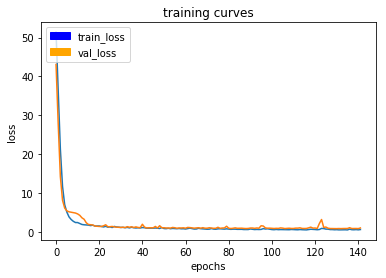

41/41 [==============================] - 28s 681ms/step - loss: 0.6754 - val_loss: 1.0762
Epoch 143/200
40/41 [============================>.] - ETA: 0s - loss: 0.7034

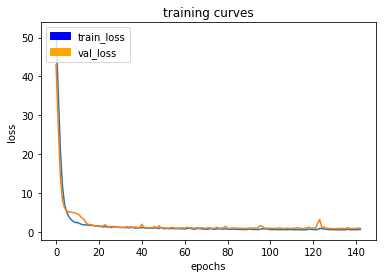

41/41 [==============================] - 28s 687ms/step - loss: 0.7018 - val_loss: 0.9690
Epoch 144/200
40/41 [============================>.] - ETA: 0s - loss: 0.6561

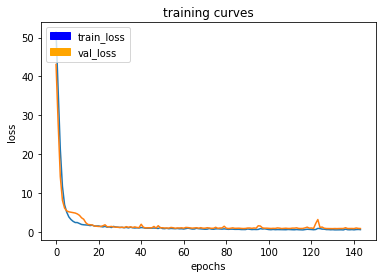

41/41 [==============================] - 28s 687ms/step - loss: 0.6544 - val_loss: 0.9286
Epoch 145/200
40/41 [============================>.] - ETA: 0s - loss: 0.5985

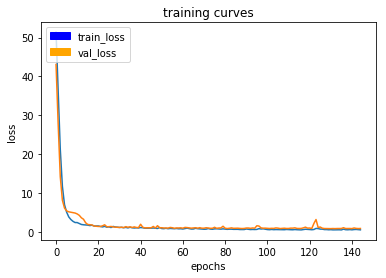

41/41 [==============================] - 28s 684ms/step - loss: 0.6008 - val_loss: 0.9478
Epoch 146/200
40/41 [============================>.] - ETA: 0s - loss: 0.6529

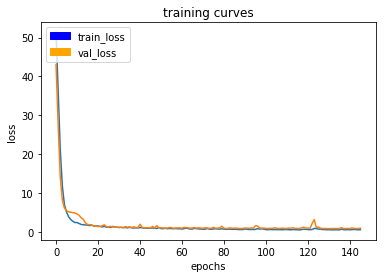

41/41 [==============================] - 28s 682ms/step - loss: 0.6512 - val_loss: 1.0166
Epoch 147/200
40/41 [============================>.] - ETA: 0s - loss: 0.5845

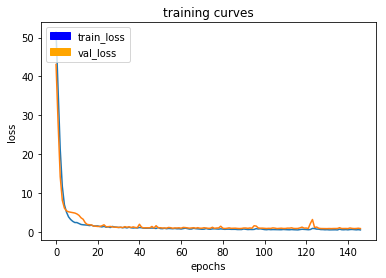

41/41 [==============================] - 28s 683ms/step - loss: 0.5825 - val_loss: 0.9245
Epoch 148/200
40/41 [============================>.] - ETA: 0s - loss: 0.5927

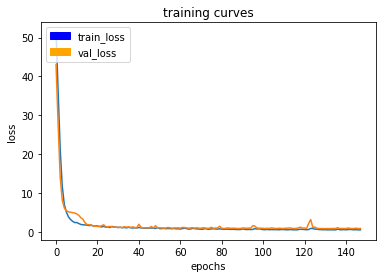

41/41 [==============================] - 28s 686ms/step - loss: 0.5925 - val_loss: 0.9610
Epoch 149/200
40/41 [============================>.] - ETA: 0s - loss: 0.5790

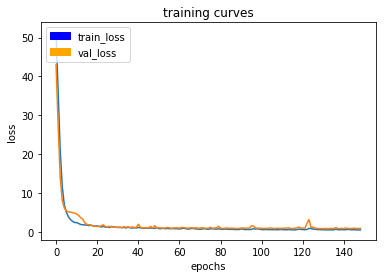

41/41 [==============================] - 28s 682ms/step - loss: 0.5773 - val_loss: 0.9659
Epoch 150/200
40/41 [============================>.] - ETA: 0s - loss: 0.5788

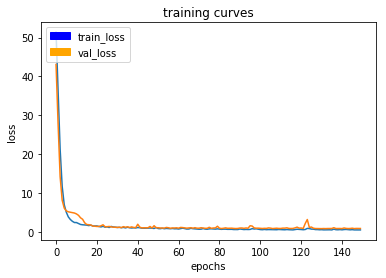

41/41 [==============================] - 28s 671ms/step - loss: 0.5788 - val_loss: 0.9461
Epoch 151/200
40/41 [============================>.] - ETA: 0s - loss: 0.5613

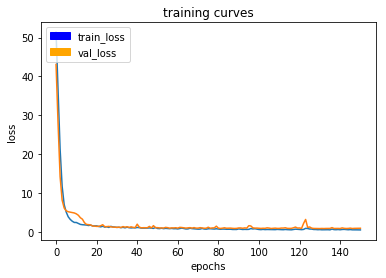

41/41 [==============================] - 28s 678ms/step - loss: 0.5588 - val_loss: 0.9874
Epoch 152/200
40/41 [============================>.] - ETA: 0s - loss: 0.5748

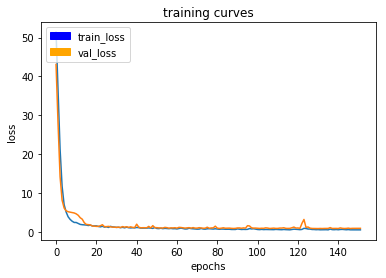

41/41 [==============================] - 28s 674ms/step - loss: 0.5745 - val_loss: 0.9677
Epoch 153/200
40/41 [============================>.] - ETA: 0s - loss: 0.5786

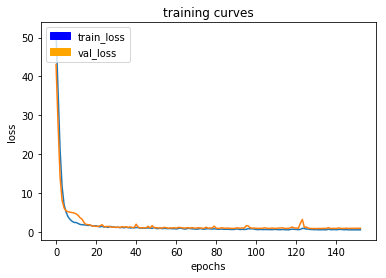

41/41 [==============================] - 28s 672ms/step - loss: 0.5813 - val_loss: 0.9847
Epoch 154/200
40/41 [============================>.] - ETA: 0s - loss: 0.5509

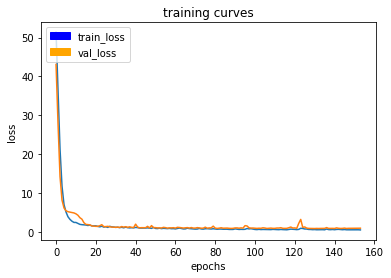

41/41 [==============================] - 28s 680ms/step - loss: 0.5498 - val_loss: 0.9890
Epoch 155/200
40/41 [============================>.] - ETA: 0s - loss: 0.5454

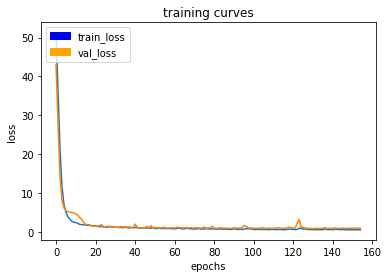

41/41 [==============================] - 28s 679ms/step - loss: 0.5442 - val_loss: 0.9981
Epoch 156/200
40/41 [============================>.] - ETA: 0s - loss: 0.5629

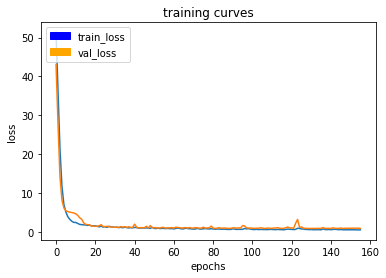

41/41 [==============================] - 27s 671ms/step - loss: 0.5629 - val_loss: 0.9272
Epoch 157/200
40/41 [============================>.] - ETA: 0s - loss: 0.5371

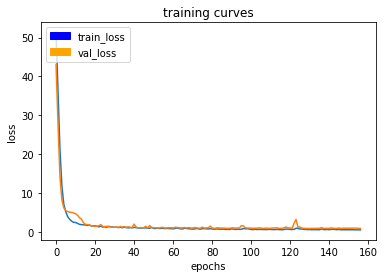

41/41 [==============================] - 28s 676ms/step - loss: 0.5389 - val_loss: 0.9240
Epoch 158/200
40/41 [============================>.] - ETA: 0s - loss: 0.5259

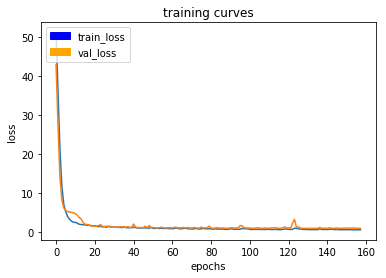

41/41 [==============================] - 28s 679ms/step - loss: 0.5236 - val_loss: 0.9478
Epoch 159/200
40/41 [============================>.] - ETA: 0s - loss: 0.5724

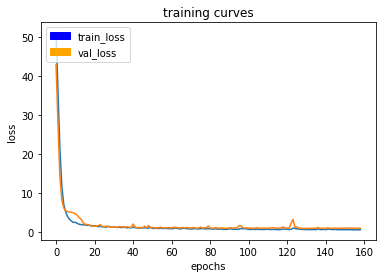

41/41 [==============================] - 28s 673ms/step - loss: 0.5724 - val_loss: 0.9681
Epoch 160/200
40/41 [============================>.] - ETA: 0s - loss: 0.5618

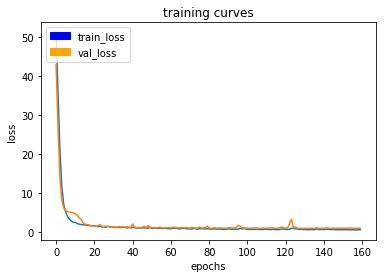

41/41 [==============================] - 28s 678ms/step - loss: 0.5623 - val_loss: 0.9483
Epoch 161/200
40/41 [============================>.] - ETA: 0s - loss: 0.5424

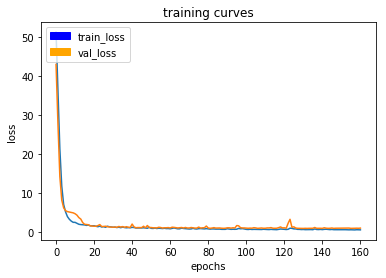

41/41 [==============================] - 28s 679ms/step - loss: 0.5414 - val_loss: 0.9830
Epoch 162/200
40/41 [============================>.] - ETA: 0s - loss: 0.5966

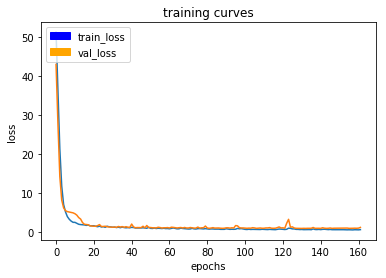

41/41 [==============================] - 28s 679ms/step - loss: 0.5955 - val_loss: 1.1656
Epoch 163/200
40/41 [============================>.] - ETA: 0s - loss: 0.6200

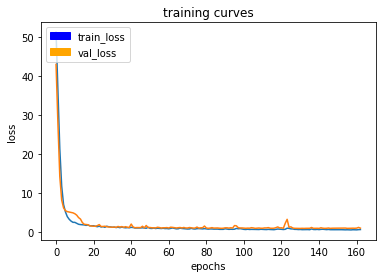

41/41 [==============================] - 28s 675ms/step - loss: 0.6191 - val_loss: 0.9766
Epoch 164/200
40/41 [============================>.] - ETA: 0s - loss: 0.6360

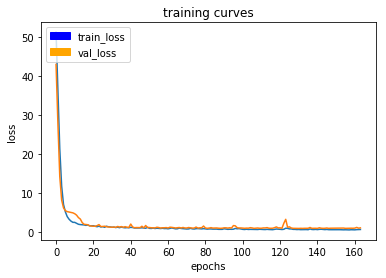

41/41 [==============================] - 27s 667ms/step - loss: 0.6344 - val_loss: 1.0418
Epoch 165/200
40/41 [============================>.] - ETA: 0s - loss: 0.5989

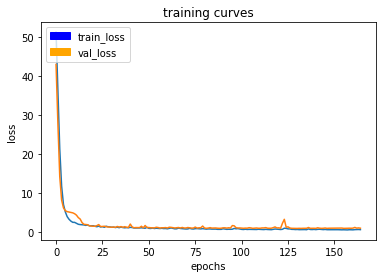

41/41 [==============================] - 28s 684ms/step - loss: 0.5980 - val_loss: 0.9635
Epoch 166/200
40/41 [============================>.] - ETA: 0s - loss: 0.6313

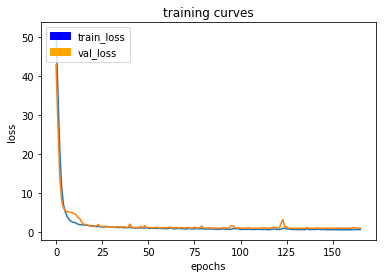

41/41 [==============================] - 27s 670ms/step - loss: 0.6307 - val_loss: 0.9615
Epoch 167/200
40/41 [============================>.] - ETA: 0s - loss: 0.6068

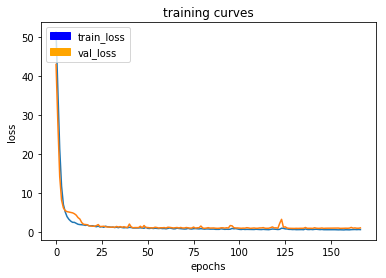

41/41 [==============================] - 28s 673ms/step - loss: 0.6046 - val_loss: 1.0381
Epoch 168/200
40/41 [============================>.] - ETA: 0s - loss: 0.5723

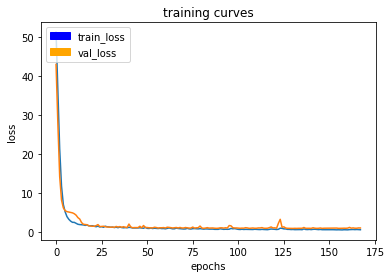

41/41 [==============================] - 28s 676ms/step - loss: 0.5715 - val_loss: 1.0189
Epoch 169/200
40/41 [============================>.] - ETA: 0s - loss: 0.5429

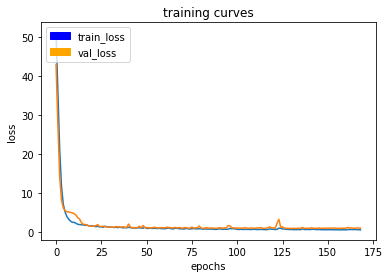

41/41 [==============================] - 28s 674ms/step - loss: 0.5441 - val_loss: 0.9647
Epoch 170/200
40/41 [============================>.] - ETA: 0s - loss: 0.5460

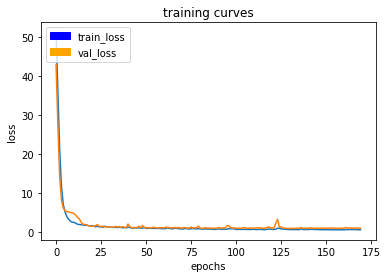

41/41 [==============================] - 28s 672ms/step - loss: 0.5435 - val_loss: 0.9756
Epoch 171/200
40/41 [============================>.] - ETA: 0s - loss: 0.5262

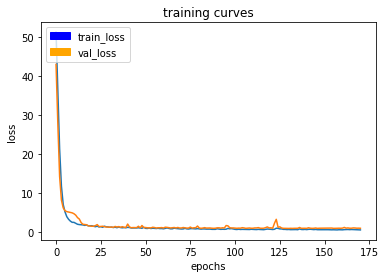

41/41 [==============================] - 28s 676ms/step - loss: 0.5253 - val_loss: 0.9453
Epoch 172/200
40/41 [============================>.] - ETA: 0s - loss: 0.5485

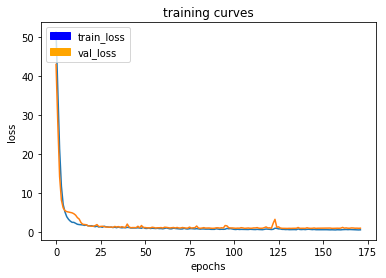

41/41 [==============================] - 28s 679ms/step - loss: 0.5491 - val_loss: 0.9620
Epoch 173/200
40/41 [============================>.] - ETA: 0s - loss: 0.5380

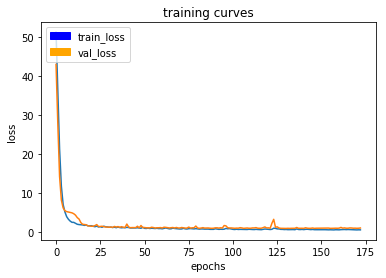

41/41 [==============================] - 28s 678ms/step - loss: 0.5389 - val_loss: 1.0139
Epoch 174/200
40/41 [============================>.] - ETA: 0s - loss: 0.5180

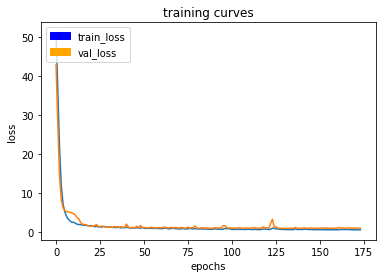

41/41 [==============================] - 27s 668ms/step - loss: 0.5169 - val_loss: 0.9495
Epoch 175/200
40/41 [============================>.] - ETA: 0s - loss: 0.5166

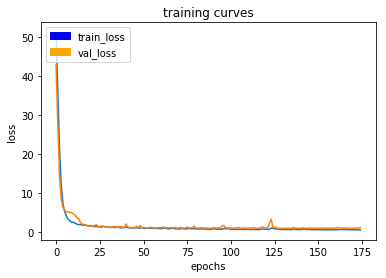

41/41 [==============================] - 28s 674ms/step - loss: 0.5155 - val_loss: 1.1269
Epoch 176/200
40/41 [============================>.] - ETA: 0s - loss: 0.5799

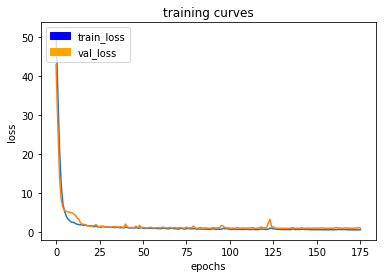

41/41 [==============================] - 28s 684ms/step - loss: 0.5807 - val_loss: 1.0035
Epoch 177/200
40/41 [============================>.] - ETA: 0s - loss: 0.5498

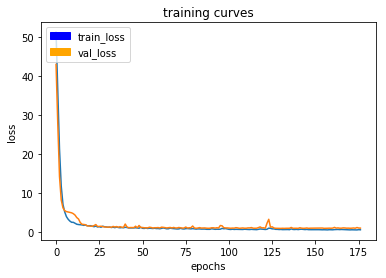

41/41 [==============================] - 28s 677ms/step - loss: 0.5511 - val_loss: 0.9748
Epoch 178/200
40/41 [============================>.] - ETA: 0s - loss: 0.5812

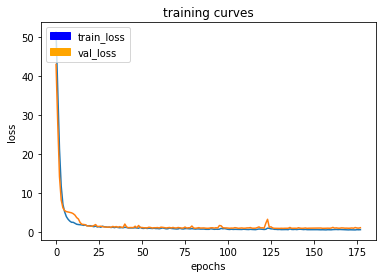

41/41 [==============================] - 28s 675ms/step - loss: 0.5788 - val_loss: 1.0742
Epoch 179/200
40/41 [============================>.] - ETA: 0s - loss: 0.5805

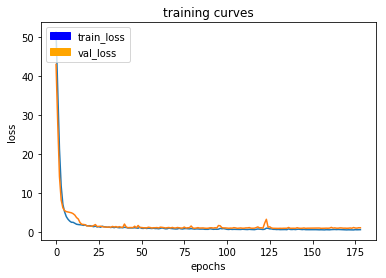

41/41 [==============================] - 28s 673ms/step - loss: 0.5812 - val_loss: 1.0632
Epoch 180/200
40/41 [============================>.] - ETA: 0s - loss: 0.6197

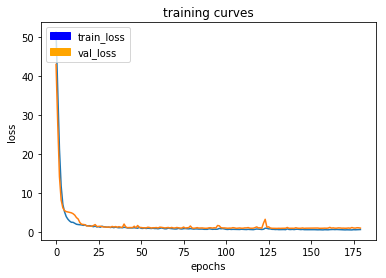

41/41 [==============================] - 28s 675ms/step - loss: 0.6169 - val_loss: 0.9778
Epoch 181/200
40/41 [============================>.] - ETA: 0s - loss: 0.5360

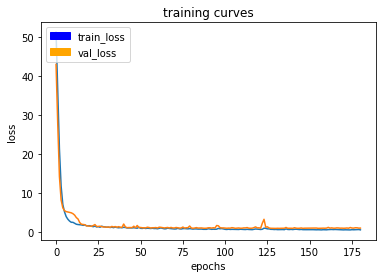

41/41 [==============================] - 28s 677ms/step - loss: 0.5366 - val_loss: 0.9793
Epoch 182/200
40/41 [============================>.] - ETA: 0s - loss: 0.5773

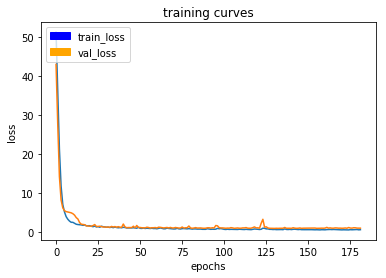

41/41 [==============================] - 28s 674ms/step - loss: 0.5762 - val_loss: 0.9624
Epoch 183/200
40/41 [============================>.] - ETA: 0s - loss: 0.5566

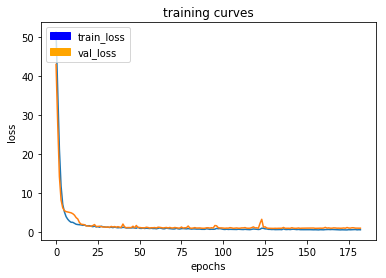

41/41 [==============================] - 28s 674ms/step - loss: 0.5543 - val_loss: 0.9571
Epoch 184/200
40/41 [============================>.] - ETA: 0s - loss: 0.5560

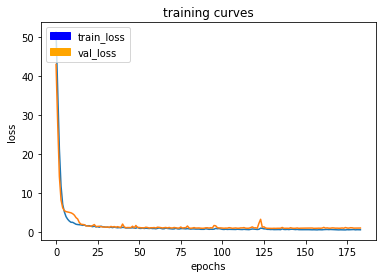

41/41 [==============================] - 28s 678ms/step - loss: 0.5535 - val_loss: 0.9997
Epoch 185/200
40/41 [============================>.] - ETA: 0s - loss: 0.5265

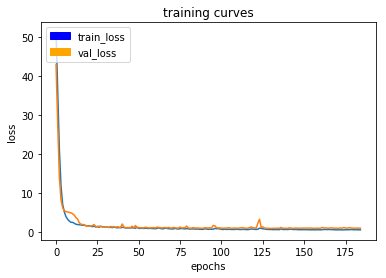

41/41 [==============================] - 28s 672ms/step - loss: 0.5285 - val_loss: 0.9603
Epoch 186/200
40/41 [============================>.] - ETA: 0s - loss: 0.5376

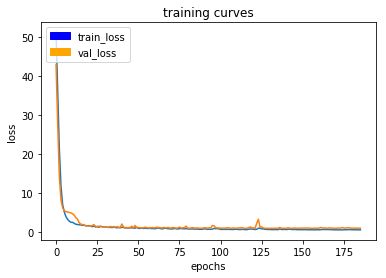

41/41 [==============================] - 28s 680ms/step - loss: 0.5410 - val_loss: 0.9593
Epoch 187/200
40/41 [============================>.] - ETA: 0s - loss: 0.5091

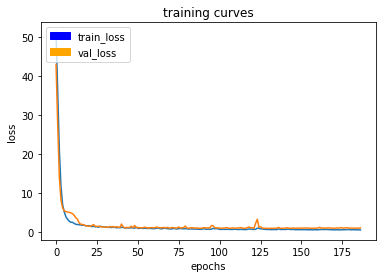

41/41 [==============================] - 27s 668ms/step - loss: 0.5115 - val_loss: 1.0256
Epoch 188/200
40/41 [============================>.] - ETA: 0s - loss: 0.5047

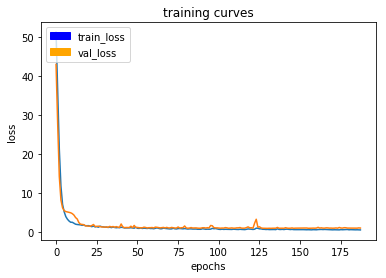

41/41 [==============================] - 28s 674ms/step - loss: 0.5053 - val_loss: 0.9834
Epoch 189/200
40/41 [============================>.] - ETA: 0s - loss: 0.5157

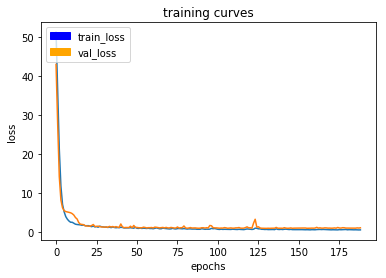

41/41 [==============================] - 28s 677ms/step - loss: 0.5154 - val_loss: 1.0398
Epoch 190/200
40/41 [============================>.] - ETA: 0s - loss: 0.5090

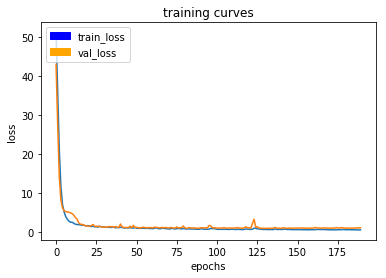

41/41 [==============================] - 28s 674ms/step - loss: 0.5118 - val_loss: 1.0566
Epoch 191/200
40/41 [============================>.] - ETA: 0s - loss: 0.5637

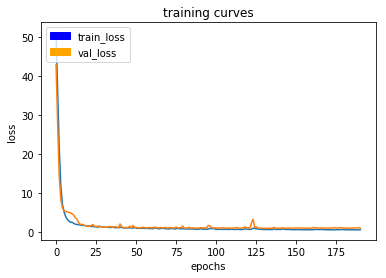

41/41 [==============================] - 28s 675ms/step - loss: 0.5613 - val_loss: 0.9967
Epoch 192/200
40/41 [============================>.] - ETA: 0s - loss: 0.6699

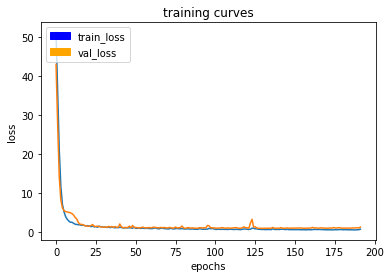

41/41 [==============================] - 27s 671ms/step - loss: 0.6895 - val_loss: 1.2434
Epoch 193/200
40/41 [============================>.] - ETA: 0s - loss: 0.8673

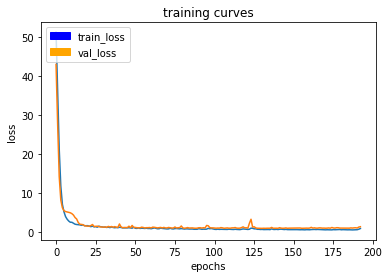

41/41 [==============================] - 28s 677ms/step - loss: 0.8691 - val_loss: 1.3254
Epoch 194/200
40/41 [============================>.] - ETA: 0s - loss: 0.8262

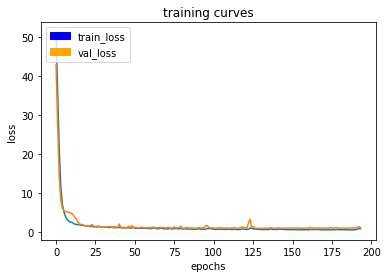

41/41 [==============================] - 28s 679ms/step - loss: 0.8314 - val_loss: 1.1282
Epoch 195/200
40/41 [============================>.] - ETA: 0s - loss: 0.6232

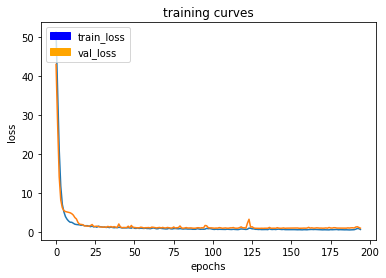

41/41 [==============================] - 28s 677ms/step - loss: 0.6246 - val_loss: 0.9505
Epoch 196/200
40/41 [============================>.] - ETA: 0s - loss: 0.5661

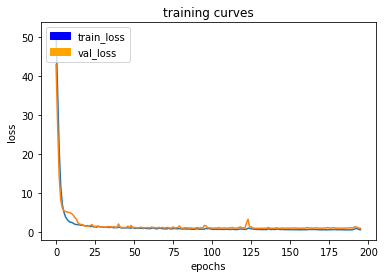

41/41 [==============================] - 28s 677ms/step - loss: 0.5657 - val_loss: 0.9433
Epoch 197/200
40/41 [============================>.] - ETA: 0s - loss: 0.5558

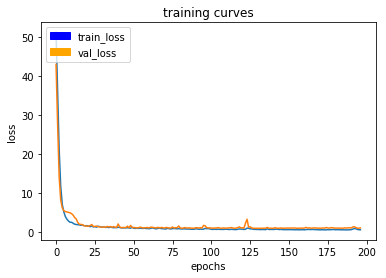

41/41 [==============================] - 28s 678ms/step - loss: 0.5496 - val_loss: 1.0143
Epoch 198/200
40/41 [============================>.] - ETA: 0s - loss: 0.5463

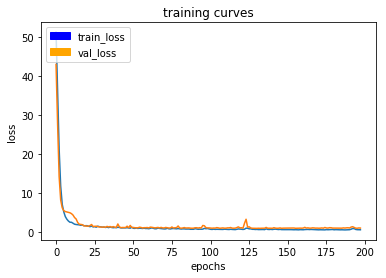

41/41 [==============================] - 28s 678ms/step - loss: 0.5439 - val_loss: 0.9763
Epoch 199/200
40/41 [============================>.] - ETA: 0s - loss: 0.5257

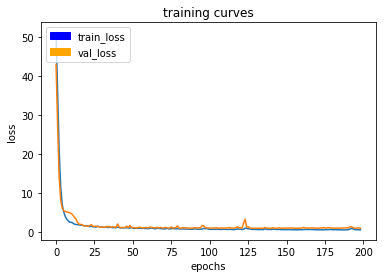

41/41 [==============================] - 28s 676ms/step - loss: 0.5311 - val_loss: 0.9660
Epoch 200/200
40/41 [============================>.] - ETA: 0s - loss: 0.5259

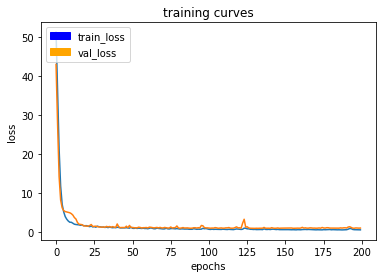

41/41 [==============================] - 28s 675ms/step - loss: 0.5238 - val_loss: 0.9790


In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Define the Keras model and compile it for training
model = models.Model(inputs=inputs, outputs=output_layer)

model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy')

# Data iterators for loading the training and validation data
train_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                               data_folder=os.path.join('..', 'data', 'train'),
                                               image_shape=image_shape,
                                               shift_aug=True)

val_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                             data_folder=os.path.join('..', 'data', 'validation'),
                                             image_shape=image_shape)

logger_cb = plotting_tools.LoggerPlotter()
callbacks = [logger_cb]

model.fit_generator(train_iter,
                    steps_per_epoch = steps_per_epoch, # the number of batches per epoch,
                    epochs = num_epochs, # the number of epochs to train for,
                    validation_data = val_iter, # validation iterator
                    validation_steps = validation_steps, # the number of batches to validate on
                    callbacks=callbacks,
                    workers = workers)

In [12]:
# Save your trained model weights
weight_file_name = 'model_weights'
model_tools.save_network(model, weight_file_name)
print(model)


Consider using a TensorFlow optimizer from `tf.train`.


## Prediction <a id='prediction'></a>

Now that you have your model trained and saved, you can make predictions on your validation dataset. These predictions can be compared to the mask images, which are the ground truth labels, to evaluate how well your model is doing under different conditions.

There are three different predictions available from the helper code provided:
- **patrol_with_targ**: Test how well the network can detect the hero from a distance.
- **patrol_non_targ**: Test how often the network makes a mistake and identifies the wrong person as the target.
- **following_images**: Test how well the network can identify the target while following them.

In [13]:
# If you need to load a model which you previously trained you can uncomment the codeline that calls the function below.

# weight_file_name = 'model_weights'
# restored_model = model_tools.load_network(weight_file_name)

The following cell will write predictions to files and return paths to the appropriate directories.
The `run_num` parameter is used to define or group all the data for a particular model run. You can change it for different runs. For example, 'run_1', 'run_2' etc.

In [14]:
run_num = 'run_1'

val_with_targ, pred_with_targ = model_tools.write_predictions_grade_set(model,
                                        run_num,'patrol_with_targ', 'sample_evaluation_data') 

val_no_targ, pred_no_targ = model_tools.write_predictions_grade_set(model, 
                                        run_num,'patrol_non_targ', 'sample_evaluation_data') 

val_following, pred_following = model_tools.write_predictions_grade_set(model,
                                        run_num,'following_images', 'sample_evaluation_data')

Now lets look at your predictions, and compare them to the ground truth labels and original images.
Run each of the following cells to visualize some sample images from the predictions in the validation set.

In [15]:
# images while following the target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','following_images', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
    

IndexError: list index out of range

In [ ]:
# images while at patrol without target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_non_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
 

In [ ]:
   
# images while at patrol with target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_with_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)

## Evaluation <a id='evaluation'></a>
Evaluate your model! The following cells include several different scores to help you evaluate your model under the different conditions discussed during the Prediction step. 

In [ ]:
# Scores for while the quad is following behind the target. 
true_pos1, false_pos1, false_neg1, iou1 = scoring_utils.score_run_iou(val_following, pred_following)

In [ ]:
# Scores for images while the quad is on patrol and the target is not visable
true_pos2, false_pos2, false_neg2, iou2 = scoring_utils.score_run_iou(val_no_targ, pred_no_targ)

In [ ]:
# This score measures how well the neural network can detect the target from far away
true_pos3, false_pos3, false_neg3, iou3 = scoring_utils.score_run_iou(val_with_targ, pred_with_targ)

In [ ]:
# Sum all the true positives, etc from the three datasets to get a weight for the score
true_pos = true_pos1 + true_pos2 + true_pos3
false_pos = false_pos1 + false_pos2 + false_pos3
false_neg = false_neg1 + false_neg2 + false_neg3

weight = true_pos/(true_pos+false_neg+false_pos)
print(weight)

In [ ]:
# The IoU for the dataset that never includes the hero is excluded from grading
final_IoU = (iou1 + iou3)/2
print(final_IoU)

In [ ]:
# And the final grade score is 
final_score = final_IoU * weight
print(final_score)